<a href="https://colab.research.google.com/github/manreddyr/ensemble-forecasting-on-air-quality-index/blob/main/india_s_air_quality_eda_ensemble_forecasting_pt_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble Foresting on Indian Cities Air Quality

<img src='https://imgur.com/jrFo9gv.jpg' width=25000px>

## **`Problem statement`**

In this Project I will be using ensemble forecasting to forecast India's Air Quality across 453 cities.

**`Ensemble Forecasting:`**

A technique used in numerical weather prediction is ensemble forecasting. Instead of making a single forecast of the most likely weather, a set of forecasts is produced. The goal of this series of projections is to provide a general idea of the spectrum of potential future atmospheric situations.


### **`Data Description:`**
The Central Pollution Control Board (CPCB), which is the official website of the Government of India, was the source of the data used in this project. The CPCB has made the information available to the public, and it is accessible there: https://cpcb.nic.in


### **`Data Field Information:`**

`Stations_Info.CSV`

This file can be used as a resource to learn pertinent details about individual stations, facilitating further analysis and investigation of the gathered data.

The "stations_info" file is a CSV file that contains information about different stations.

The file has the following headers:
"file_name," "state," "city," "agency," "station_location," "start_month," "start_month_num," and "start_year."

The "file_name" column represents the name of the file associated with the station.

The "state" column specifies the state where the station is located.

The "city" column indicates the city where the station is situated.

The "agency" column denotes the agency responsible for managing the station.

The "station_location" column provides additional details about the exact location of the station.

The "start_month" column represents the starting month of data collection at the station.

the "start_month_num" column provides the corresponding numeric representation of the starting month.

the "start_year" column indicates the year when data collection began at the station.

<img src='https://i.imgur.com/gdICvLI.jpg' width=500px>


## STEPS

* Install and import libraries
* Load State Information
* Data Preprocessing
    * Feature Reduction
    * Missing Values
        * Dataset's Null Count Information
        * Drop Nulls by Threshold
* Exploratory Data Analysis (EDA)
    * Time Frequencies
    * Year Slices
    * PairPlot
    * Correlation Matrix
* Feature Engineering
    * Drop Correlated Features
    * Resampling
    * Outlier Detection and Removal
    * Handling Missing Values
    * Date Component Features
    * Lag Features
* Time Series Forecasting
    * Dataset Preparation
    * Ensemble Methods
        * Cross-Validation
        * Hyperparameter Tuning
        * Feature Importances
        * Future Predictions
* Model Persistence
    


# Install and import libraries


In [85]:
!pip install opendatasets -q       # To Download Data from Kaggle
import os                          # operating system interfaces
import glob                        # working with OS pathnames
import time                        # time processing
import numpy as np                 # linear algebra
import pandas as pd                # data processing, CSV file I/O
import matplotlib.pyplot as plt    # data visualization purposes
import seaborn as sns              # statistical data visualization
sns.set_theme()
import opendatasets as od

# sklearn imports
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    HistGradientBoostingRegressor
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)
from sklearn.model_selection import (
    cross_val_score,
    TimeSeriesSplit,
    RandomizedSearchCV
)

import xgboost as xgb                       # Extreme Gradient Boosting library
from IPython.display import clear_output    # Display function to clear notebook cell's output

In [86]:
download_url = 'https://www.kaggle.com/datasets/abhisheksjha/time-series-air-quality-data-of-india-2010-2023' #kaggle URL of the dataset
od.download(download_url)  # downloading the dataset

Skipping, found downloaded files in "./time-series-air-quality-data-of-india-2010-2023" (use force=True to force download)


## Load State Information

First we define the state and its appropriate code for reference as well as all the available metrics.

In [87]:
df_states = pd.read_csv('/content/time-series-air-quality-data-of-india-2010-2023/stations_info.csv')
df_states.drop(columns=['agency', 'station_location', 'start_month'], inplace=True)
df_states.head()

,file_name,state,city,start_month_num,start_year
0,AP001,Andhra Pradesh,Tirupati,7,2016
1,AP002,Andhra Pradesh,Vijayawada,5,2017
2,AP003,Andhra Pradesh,Visakhapatnam,7,2017
3,AP004,Andhra Pradesh,Rajamahendravaram,9,2017
4,AP005,Andhra Pradesh,Amaravati,11,2017


In [88]:
unique_states = df_states['state'].unique()
unique_states

array(['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar',
       'Chhattisgarh', 'Chandigarh', 'Delhi', 'Gujarat',
       'Himachal Pradesh', 'Haryana', 'Jharkhand', 'Jammu and Kashmir',
       'Karnataka', 'Kerala', 'Maharashtra', 'Meghalaya', 'Manipur',
       'Madhya Pradesh', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab',
       'Puducherry', 'Rajasthan', 'Sikkim', 'Telangana', 'Tamil Nadu',
       'Tripura', 'Uttarakhand', 'Uttar Pradesh', 'West Bengal'],
      dtype=object)

We are working with a large dataset which is split in multiple files (for each city in each state), collected through different agencies. It is expected
that each agency collected metrics in various formats. In addition to this, agencies started collecting data at different dates. We should check for all these notes.

First I will create a function that will return a dataframe combining all agency measurements in a given state.

In [89]:
DATASET_SRC='/content/time-series-air-quality-data-of-india-2010-2023'

In [90]:
def combine_state_df(state_name):
    '''
    Combine all state files into a single dataframe and attaching the city information.

    Parameters
    ----------
        state_name (str): The name of the state

    Return
    ------
        df (DataFrame): The combined dataframe from all files of a specific state
    '''

    state_code = df_states[df_states['state'] == state_name]['file_name'].iloc[0][:2]
    state_files = glob.glob(f'{DATASET_SRC}/{state_code}*.csv')
    print(f'Combining a total of {len(state_files)} files...\n')

    combined_df = []

    for state_file in state_files:
        file_name = state_file.split(f'{DATASET_SRC}/')[1][0:-4]
        file_df = pd.read_csv(state_file)
        file_df['city'] = df_states[df_states['file_name'] == file_name]['city'].values[0]
        file_df['city'] = file_df['city'].astype('string')
        combined_df.append(file_df)

    return pd.concat(combined_df)

In order to understand the properties of the dataset provided, I will take a closer look on the measurements for India's capital state, Delhi.

In [91]:
df = combine_state_df('Delhi')
df.info()

Combining a total of 40 files...

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2796171 entries, 0 to 116111
Data columns (total 60 columns):
 #   Column               Dtype  
---  ------               -----  
 0   From Date            object 
 1   To Date              object 
 2   PM2.5 (ug/m3)        float64
 3   PM10 (ug/m3)         float64
 4   NO (ug/m3)           float64
 5   NO2 (ug/m3)          float64
 6   NOx (ppb)            float64
 7   NH3 (ug/m3)          float64
 8   SO2 (ug/m3)          float64
 9   CO (mg/m3)           float64
 10  Ozone (ug/m3)        float64
 11  Benzene (ug/m3)      float64
 12  Toluene (ug/m3)      float64
 13  Eth-Benzene (ug/m3)  float64
 14  MP-Xylene (ug/m3)    float64
 15  RH (%)               float64
 16  WS (m/s)             float64
 17  WD (degree)          float64
 18  SR (W/mt2)           float64
 19  BP (mmHg)            float64
 20  VWS (m/s)            float64
 21  CH4 ()               float64
 22  Xylene (ug/m3)       float64
 23 

From these dataframe details we can see this state's feature vector comprises 58 different metrics and a total of 2796171 records!

## Data Preprocessing

I noticed that there are two features, `From Date` and `To Date` which are both Pandas objects. These feature vectors describe a one hour
window for all the metric collected at that point. Since we are dealing with time series data, it is also common to use a datetime index. I decided
to keep the `From Date` as index and transform it from a Pandas object into the datetime format.

In [92]:
# Make the 'From Date' column the index as datetime
def create_dt_index(dataframe):
    dataframe = dataframe.drop(columns='To Date')
    dataframe['From Date'] = pd.to_datetime(dataframe['From Date'])
    dataframe = dataframe.rename(columns={'From Date': 'datetime'})
    return dataframe.set_index('datetime')

In [93]:
df = create_dt_index(df)
df.head(2)

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),...,CO (ng/m3),SR (),MP-Xylene (),WD (degree C),Eth-Benzene (),Xylene (),MH (m),HCHO (ug/m3),Hg (ug/m3),Temp (ug/m3)
datetime,,,,,,,,,,,,,,,,,,,,,
2020-11-13 14:00:00,51.48,98.20,NaN,60.77,NaN,NaN,3.17,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-13 15:00:00,54.46,102.92,NaN,57.50,NaN,0.2,2.42,NaN,1.26,0.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Feature Reduction

As observed from the dataframe's info, some features appear to be similar. I will try to identify potential similarities between such features, and merge them.

In [94]:
# Helper function to plot groups of data into subplots
def plot_feature_similarities(dataframe, feature_groups, columns=2):
    rows = int((len(feature_groups)/columns)//1)
    fig, axes = plt.subplots(rows, columns, figsize=(13, 4*rows))
    fig.tight_layout(pad=3.0)

    row_num = 0
    col_num = 0
    for pos, group in enumerate(feature_groups):
        # Move to new row
        if pos % columns == 0 and pos != 0:
            row_num += 1
            col_num = 0

        for feature in feature_groups[group]:
            df_feature = dataframe[dataframe[feature].notnull()][feature]
            df_feature = df_feature.groupby([df_feature.index.year]).mean(numeric_only=True)
            sns.lineplot(data=df_feature, label=feature, ax=axes[row_num, col_num])
        axes[row_num, col_num].set_title(group)
        axes[row_num, col_num].set(xlabel=None)
        col_num += 1

    plt.plot()

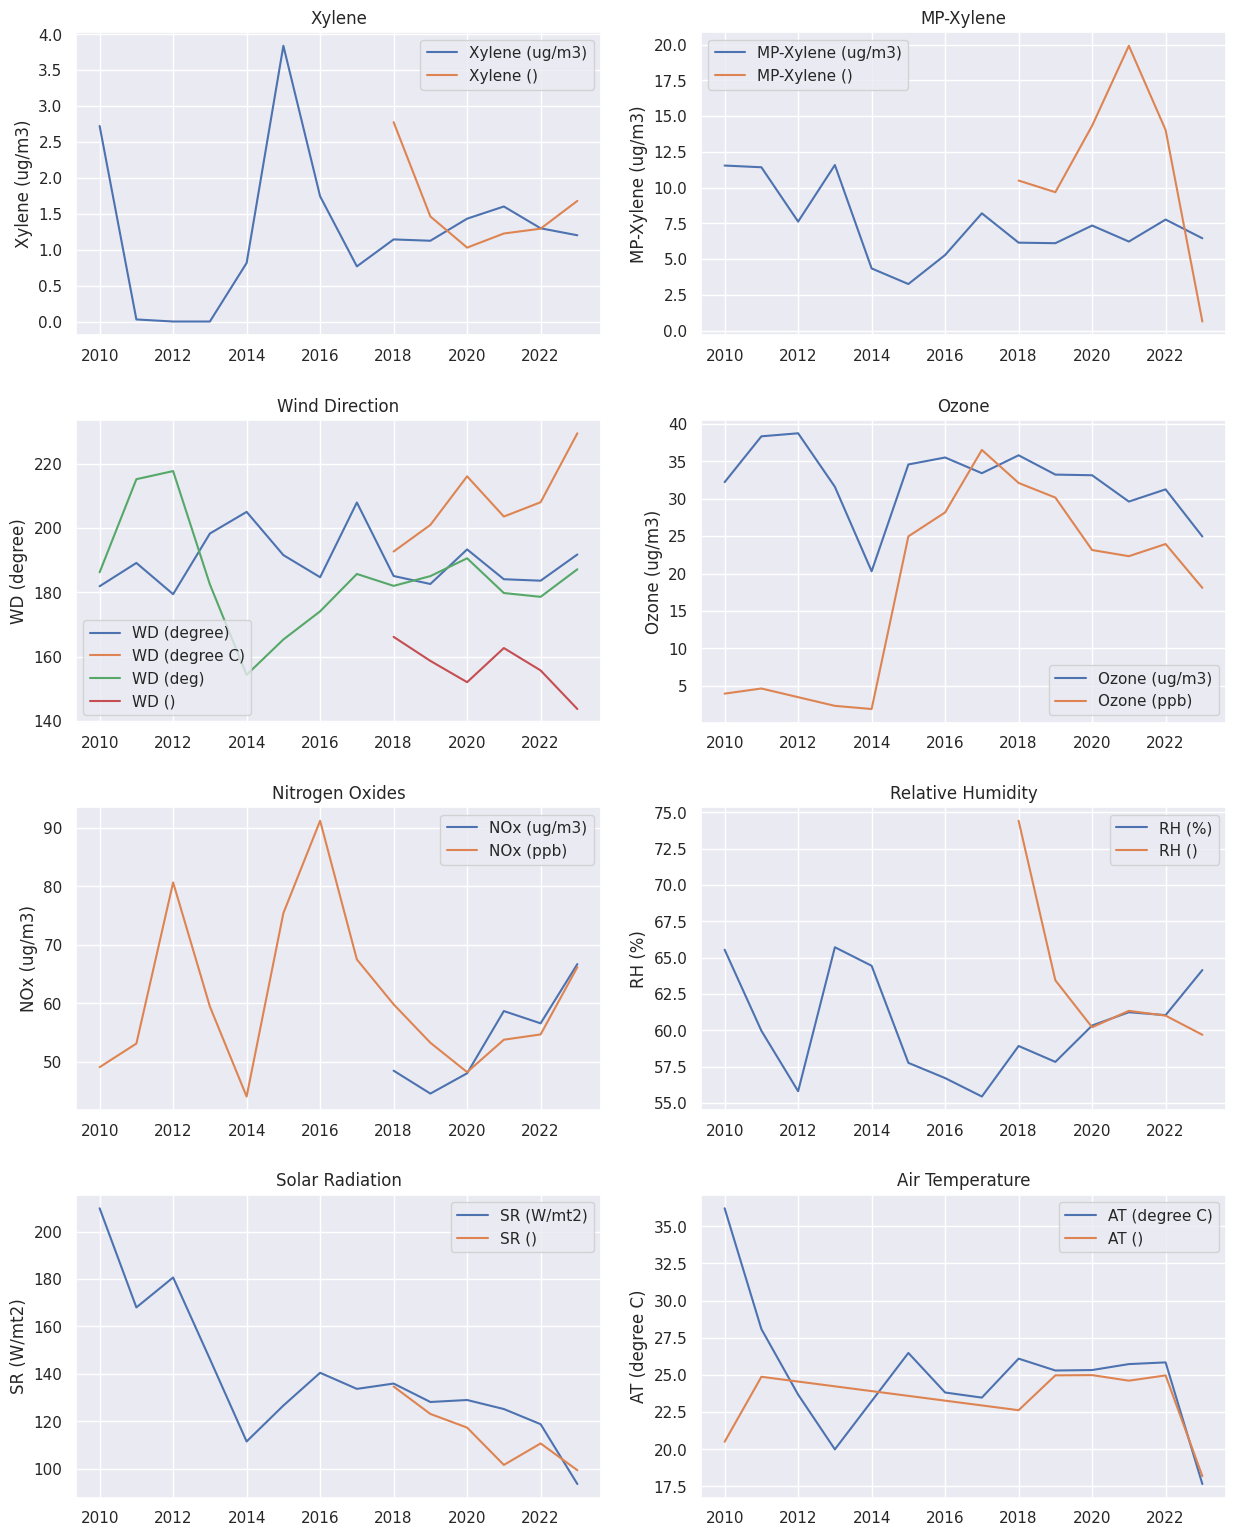

In [95]:
groups = {
    'Xylene':            ['Xylene (ug/m3)', 'Xylene ()'],
    "MP-Xylene":         ['MP-Xylene (ug/m3)', 'MP-Xylene ()'],
    'Wind Direction':    ["WD (degree)", "WD (degree C)", "WD (deg)", "WD ()"],
    'Ozone':             ['Ozone (ug/m3)', 'Ozone (ppb)'],
    'Nitrogen Oxides':   ['NOx (ug/m3)', 'NOx (ppb)'],
    'Relative Humidity': ['RH (%)', 'RH ()'],
    'Solar Radiation':   ['SR (W/mt2)', 'SR ()'],
    'Air Temperature':   ['AT (degree C)', 'AT ()']
}

plot_feature_similarities(df, groups, columns=2)

It seems like some of the features are capturing the same metric units as others. This is a good indication and we can double confirm by using the Pandas `describe`.

In [96]:
all_groups = [item for sublist in list(groups.values()) for item in sublist]
df[all_groups].describe().applymap(lambda x: f"{x:0.3f}")

,Xylene (ug/m3),Xylene (),MP-Xylene (ug/m3),MP-Xylene (),WD (degree),WD (degree C),WD (deg),WD (),Ozone (ug/m3),Ozone (ppb),NOx (ug/m3),NOx (ppb),RH (%),RH (),SR (W/mt2),SR (),AT (degree C),AT ()
count,242944.000,34578.000,264768.000,29205.000,813361.000,43888.000,655812.000,122463.000,1874697.000,47576.000,86086.000,1876466.000,1611483.000,39722.000,1555347.000,43267.000,1110834.000,83016.000
mean,1.337,1.319,7.040,13.824,186.417,205.871,184.905,157.480,32.370,25.864,52.076,56.894,59.893,62.812,130.106,116.041,25.136,24.178
std,5.762,3.348,13.603,19.986,94.905,88.418,80.286,91.992,34.778,19.535,59.768,70.730,22.548,20.497,180.273,172.197,8.561,8.426
min,0.000,0.000,0.010,0.010,0.020,1.200,0.030,1.300,0.010,0.050,0.100,0.000,0.010,0.820,0.000,2.720,0.100,1.880
25%,0.000,0.000,1.210,2.890,104.850,119.570,121.010,86.950,8.550,13.530,17.380,16.980,43.120,46.450,5.580,3.480,18.580,17.420
50%,0.000,0.400,2.940,7.040,187.380,230.435,185.310,147.830,19.600,20.480,31.050,31.680,61.330,63.820,29.500,11.350,26.400,25.380
75%,1.010,1.400,7.410,15.760,268.950,285.550,252.050,229.700,43.150,33.130,61.100,64.280,78.000,80.000,216.210,174.735,31.500,30.300
max,476.310,231.000,491.510,286.010,360.000,356.520,359.590,359.700,200.000,198.470,498.850,500.000,100.000,99.200,1995.000,836.420,58.900,56.270


I was able to merge the following features. The rest have too many missing values so we are going to drop them.

In [97]:
reduction_groups = {
    "Xylene (ug/m3)":    ["Xylene ()"],
    "MP-Xylene (ug/m3)": ["MP-Xylene ()"],
    "Benzene (ug/m3)":   ["Benzene ()"],
    "Toluene (ug/m3)":   ["Toluene ()"],
    "SO2 (ug/m3)":       ["SO2 ()"],
    "NOx (ug/m3)":       ["NOx (ppb)"],
    "Ozone (ug/m3)":     ["Ozone (ppb)"],
    "AT (degree C)":     ["AT ()"],
    "WD (degree)":       ["WD (degree C)", "WD (deg)", "WD ()"],
    "WS (m/s)":          ["WS ()"]
}

In [98]:
def merge_columns(dataframe, columns):
    '''
    Merges column records into a single column.

    Parameters
    ----------
        dataframe (DataFrame): The DataFrame to edit
        column (str): The name of the column to merge records into
        cols_to_merge (list[str]): A list of column names to retrieve records
    '''

    for column, cols_to_merge in columns.items():
        # Check if the original column exist, otherwise create it
        if column not in dataframe.columns and any(name in dataframe.columns for name in cols_to_merge):
            dataframe[column] = np.nan

        for col_name in cols_to_merge:
            if col_name in dataframe.columns:
                dataframe[column] = dataframe[column].fillna(dataframe[col_name])
                dataframe = dataframe.drop(columns=[col_name])

    return dataframe

In [99]:
df = merge_columns(df, reduction_groups)

### Missing Values

One important first thing to check now is how many missing values there are for these features.

In [100]:
df.isnull().sum().sort_values(ascending=False)

Temp (ug/m3)           2796171
Gust (m/s)             2796171
Gust (kl/h)            2796171
Variance (n)           2796171
Power (W)              2796171
CO2 (mg/m3)            2796171
Gust (km/hr)           2796171
SPM (ug/m3)            2796171
NMHC (ug/m3)           2796171
Eth-Benzene ()         2796171
CH4 ()                 2785343
HCHO (ug/m3)           2762343
Hg (ug/m3)             2761020
MH (m)                 2758723
BP ()                  2756663
RH ()                  2756449
SR ()                  2752904
CO (ng/m3)             2752432
CH4 (ug/m3)            2734776
THC (ug/m3)            2733520
CO (ug/m3)             2712197
O Xylene (ug/m3)       2611212
Eth-Benzene (ug/m3)    2568923
Xylene (ug/m3)         2518649
MP-Xylene (ug/m3)      2502198
VWS (m/s)              2370506
Temp (degree C)        2295873
RF (mm)                1899980
AT (degree C)          1602321
BP (mmHg)              1417134
NH3 (ug/m3)            1366814
Toluene (ug/m3)        1313863
Benzene 

Looks like we are dealing with a dataset which contains a lot of missing values. On a closer look we can observe that some of these feature columns are
completely empty, so we can easily drop those columns.

In [101]:
df = df.dropna(how='all')
df = df.dropna(how='all', axis='columns')

I will create a function to see both the null value count as well as the percentages.

In [102]:
# Helper function that returs a DataFrame containing the number of null values and percentages for each column
def get_null_info(dataframe):
    null_vals = dataframe.isnull().sum()

    df_null_vals = pd.concat({'Null Count': null_vals,
                              'Percent Missing (%)': round(null_vals * 100 / len(dataframe), 2)}, axis=1)

    return df_null_vals.sort_values(by=['Null Count'], ascending=False)

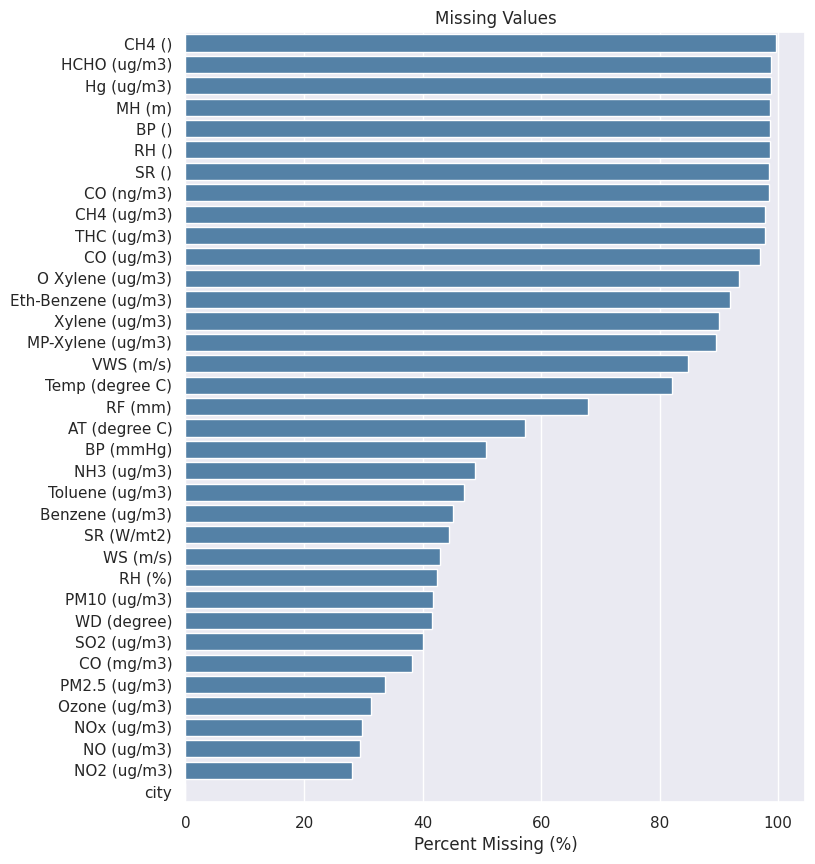

In [103]:
df_null_info = get_null_info(df)


plt.figure(figsize=(8, 10))
sns.barplot(data=df_null_info, x='Percent Missing (%)', y=df_null_info.index, orient='h', color='steelblue')
plt.title("Missing Values")
plt.show()

The barplot shows that the majority of features contain very little information.

#### Dataset's Null Count Information

So far we investigated only a single state. We may get a better feeling for the missing data if we investigate the complete dataset.

In [104]:
def get_overall_ds_info():
    features = {}
    total_records = 0

    for i, state_name in enumerate(unique_states):
        clear_output(wait=False)
        print(f"Processing state of {state_name} ({i+1}/{len(unique_states)})")

        temp_df = combine_state_df(state_name)  # Get combined state dataframe
        temp_df = create_dt_index(temp_df)      # Create datetime index
        temp_df = temp_df.dropna(how='all')     # Drop empty rows

        comparisons = get_null_info(temp_df)

        total_records += df.shape[0]

        for feature in comparisons.index:
            if feature in features:
                features[feature] += comparisons.loc[[feature]]['Null Count'].values[0]
            else:
                features[feature] = comparisons.loc[[feature]]['Null Count'].values[0]

    ds_null_info = pd.DataFrame.from_dict(features, orient='index', columns=['Null Count'])
    ds_null_info['Percent Missing (%)'] = round(ds_null_info['Null Count'] * 100 / total_records, 2)
    ds_null_info = ds_null_info.sort_values(by=['Null Count'], ascending=False)
    return ds_null_info

Processing state of West Bengal (31/31)
Combining a total of 14 files...



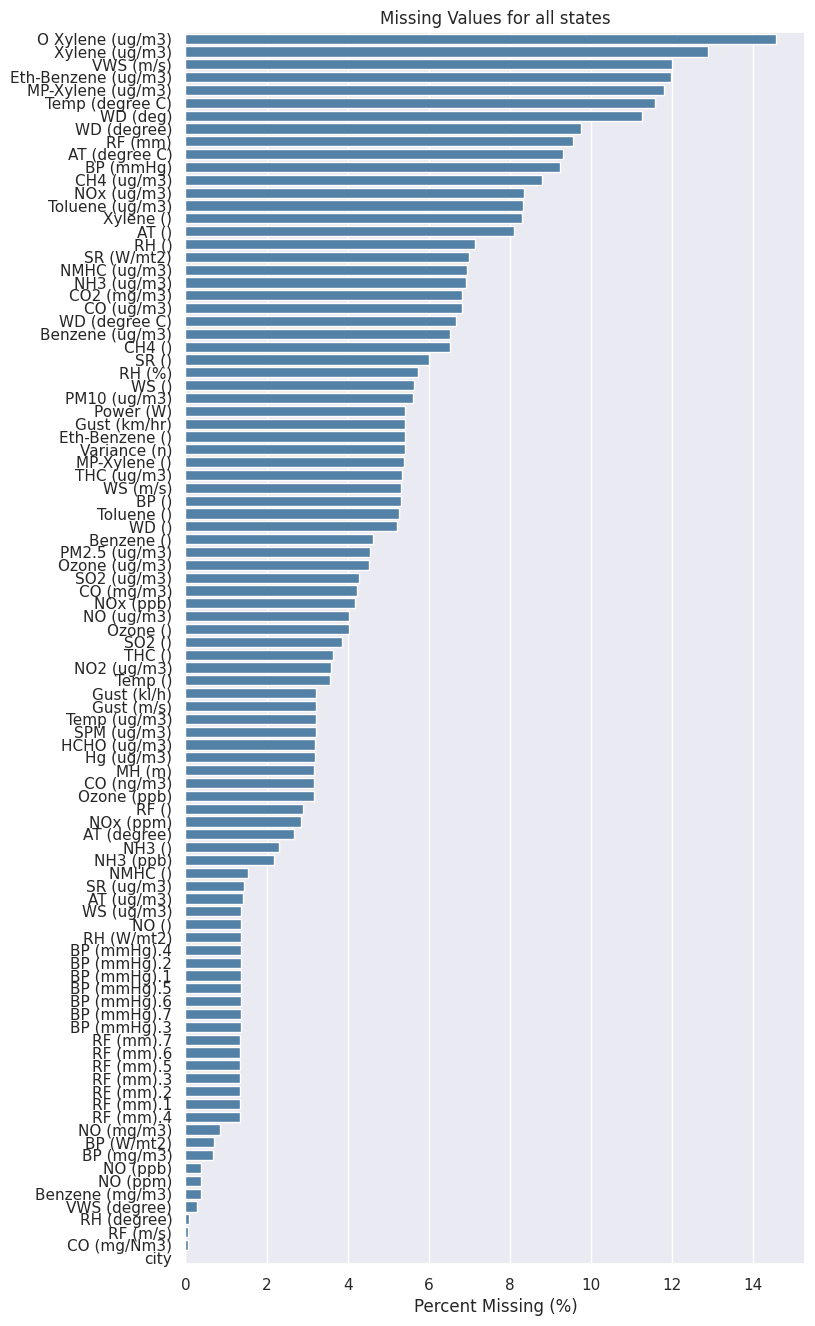

In [105]:
overall_ds_info = get_overall_ds_info()

plt.figure(figsize=(8, 16))
sns.barplot(data=overall_ds_info, x='Percent Missing (%)', y=overall_ds_info.index, orient='h', color='steelblue')
plt.title("Missing Values for all states")
plt.show()

From these barplots, we can deduce that the various states collected different kinds and amounts of metrics. Typically with datasets like these, people tend to keep
the features that contain less than 25-30% missing values, unless they contain important information.

#### Drop Nulls by Threshold

Back to our capital's dataframe, we can drop the columns which contain a certain thrueshold (i.e > 40%) of missing values.

In [106]:
# Threshold value indicating how much of the dataset needs to be not missing.
threshold = 0.6
df = df.dropna(thresh=df.shape[0]*threshold, axis=1)

In [107]:
get_null_info(df)

,Null Count,Percent Missing (%)
CO (mg/m3),1070972,38.30
PM2.5 (ug/m3),939895,33.61
Ozone (ug/m3),873898,31.25
NOx (ug/m3),833619,29.81
NO (ug/m3),821483,29.38
NO2 (ug/m3),783452,28.02
city,0,0.00


## Exploratory Data Analysis (EDA)

I am collecting the metrics (features) into several groups. This will enable better comparisons.

In [108]:
pollutants = {
    # A mixture of solid particles and liquid droplets found in the air.
    'Particulate Matter' : ['PM2.5 (ug/m3)', 'PM10 (ug/m3)'],

    # Nitrogen gases form when fuel is burned at high temperatures.
    'Nitrogen Compounds' : ['NOx (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NH3 (ug/m3)'],

    # These are found in coal tar, crude petroleum, paint, vehicle exhausts and industrial emissions.
    'Hydrocarbons' : ['Benzene (ug/m3)', 'Eth-Benzene (ug/m3)', 'Xylene (ug/m3)', 'MP-Xylene (ug/m3)', 'O Xylene (ug/m3)', 'Toluene (ug/m3)'],

    # Released from the partial combustion of carbon-containing compounds.
    'Carbon Monoxide': ['CO (mg/m3)'],

    # Released naturally by volcanic activity and is produced as a by-product of copper extraction and the burning of sulfur-bearing fossil fuels.
    'Sulfur Dioxide': ['SO2 (ug/m3)'],

    # It is created mostly the combustion of fossil fuels.
    'Ozone Concentration' : ['Ozone (ug/m3)']
}

other_metrics = {
    # Affects Earth's average temperatures
    'Solar Radiation' : ['SR (W/mt2)'],

    'Temperatures' : ['Temp (degree C)', 'AT (degree C)'],

    'Relative Humidity' : ['RH (%)'],

    'Rainfall' : ['RF (mm)'],

    'Barometric Pressure' : ['BP (mmHg)'],

    'Wind Direction' : ['WD (degree)'],

    'Wind Speed' : ['WS (m/s)']
}


### Time Frequencies

Let's start by grouping our DataFrame by various frequencies.

In [109]:
slice_groups = {
    'Group by Day':   df.groupby(pd.Grouper(freq='1D')).mean(numeric_only=True),
    'Group by Month': df.groupby(pd.Grouper(freq='1M')).mean(numeric_only=True),
    'Group by Year':  df.groupby(pd.Grouper(freq='1Y')).mean(numeric_only=True)
}

In [110]:
def plot_features_by_group(features, slice_groups):
    for feature in features:
        fig, ax = plt.subplots(1, 1, figsize=(12, 4))
        fig.suptitle(feature)

        labels = []
        for i, (group, group_df) in enumerate(slice_groups.items()):
            data_slice = group_df[group_df.columns.intersection(pollutants[feature])]

            # Keep only the NOx feature, as it combines both NO (Nitrogen Oxide) and NO2 (Nitrogen Dioxide)
            if feature == "Nitrogen Compounds":
                data_slice = data_slice.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1)

            data_slice.plot(kind="line", ax=ax)

            for column in data_slice.columns:
                labels.append(f'{column} [{group}]')

        ax.set(xlabel=None)
        ax.legend(labels)
        plt.plot()

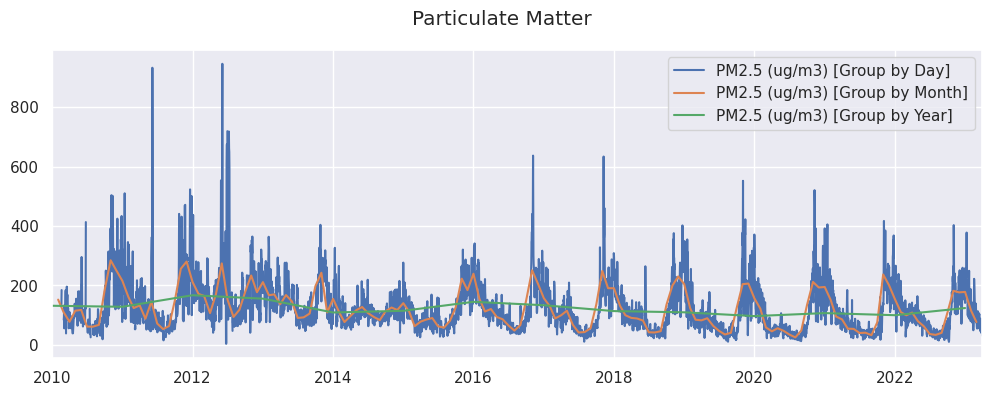

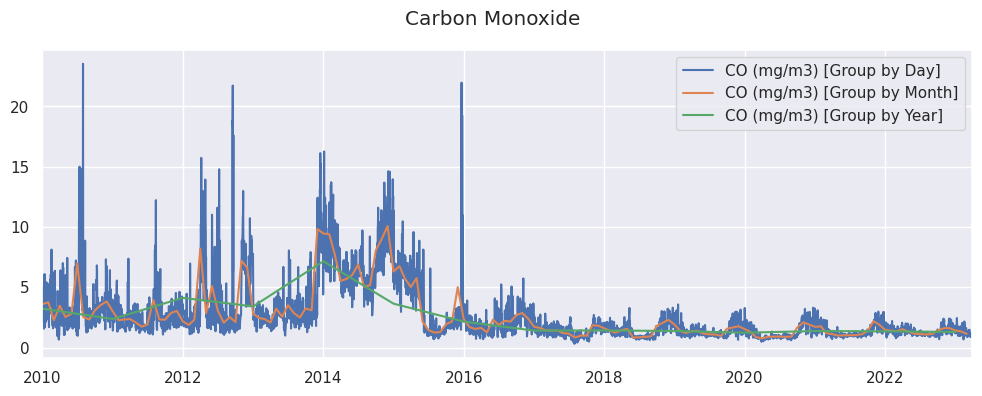

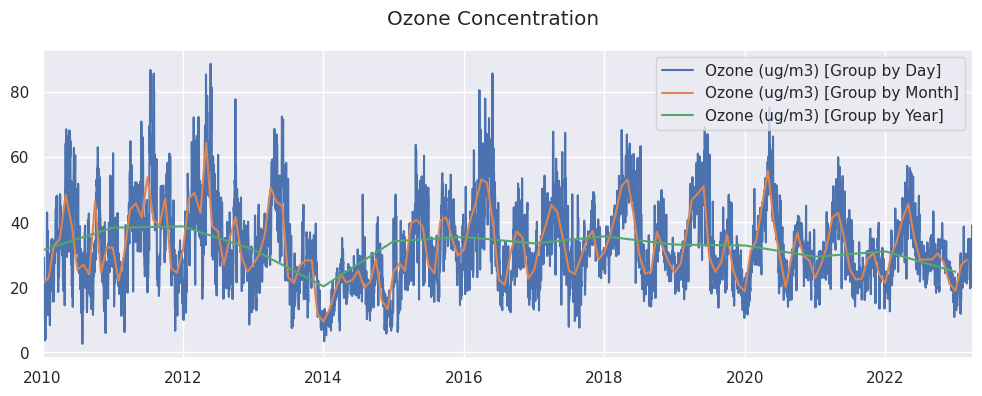

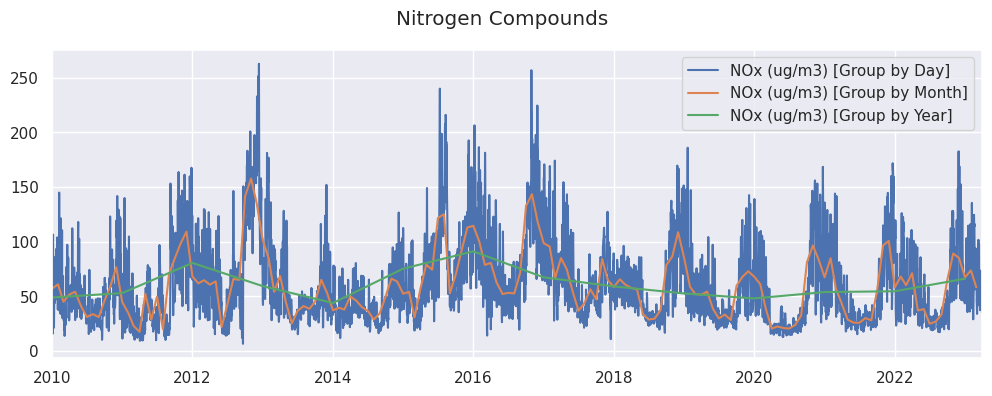

In [111]:
features_to_plot = ['Particulate Matter', 'Carbon Monoxide', 'Ozone Concentration', 'Nitrogen Compounds']
plot_features_by_group(features_to_plot, slice_groups)

### Year Slices

It looks like we are dealing with seasonal patterns on the metrics we selected. Let's dive a little bit deeper and try to understand
what's happening per season on a yearly basis. For example let's consider a slice of the data, such as the year 2019-2020.

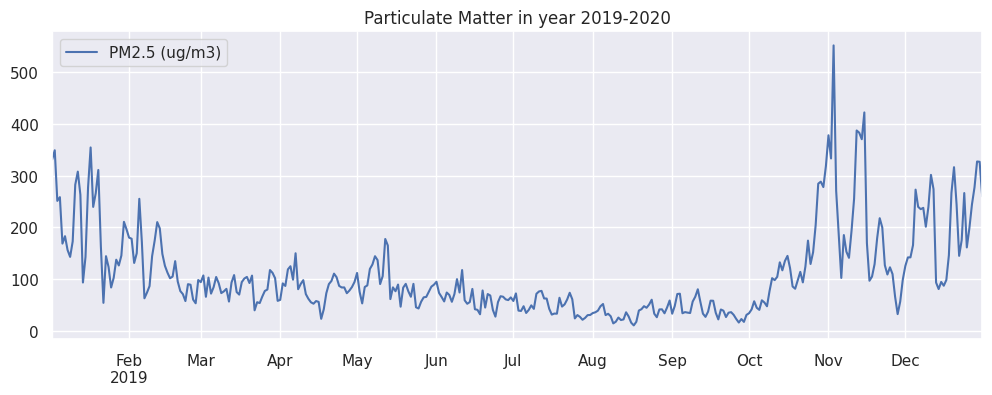

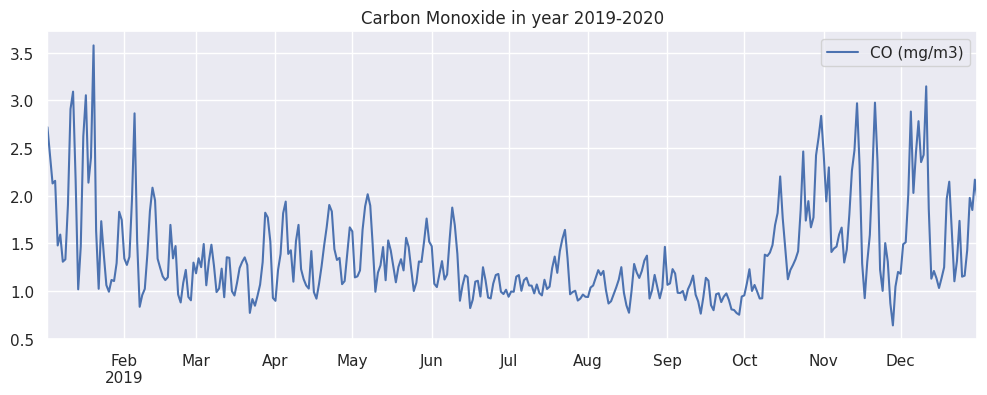

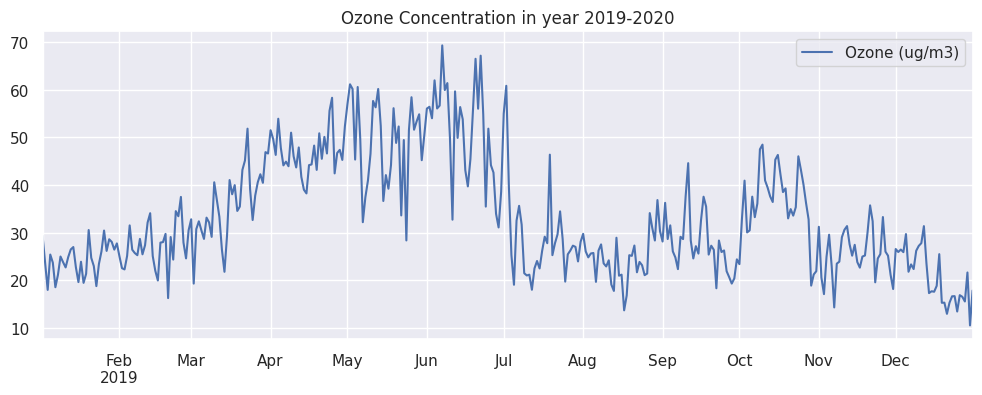

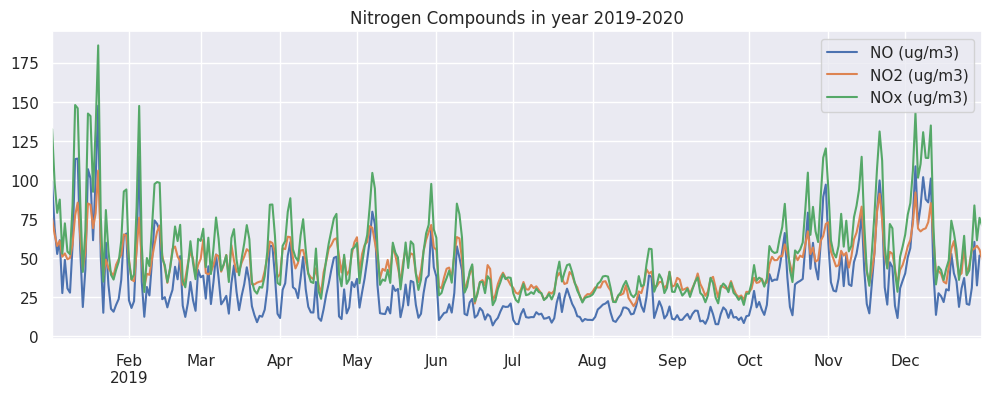

In [112]:
for feature in features_to_plot:
    data_slice = slice_groups['Group by Day'][slice_groups['Group by Day'].columns.intersection(pollutants[feature])]
    data_slice.query('datetime > 2019 and datetime < 2020').plot(title=f'{feature} in year 2019-2020', figsize=(12,4)).set(xlabel=None)

Here we can see that the values for the `Particulate Mater`, `Nitrogen Compounds` and `Carbon Monoxide`, start to increase around October
and last until approxamatelly March. For the `Ozone Concentration` metric we see an opposite result, where the maximum values in a year
are around mid May/June.

### PairPlot

We can see a better explanation on the relationships between the variables, as well as the distribution of each one through a pair plot.

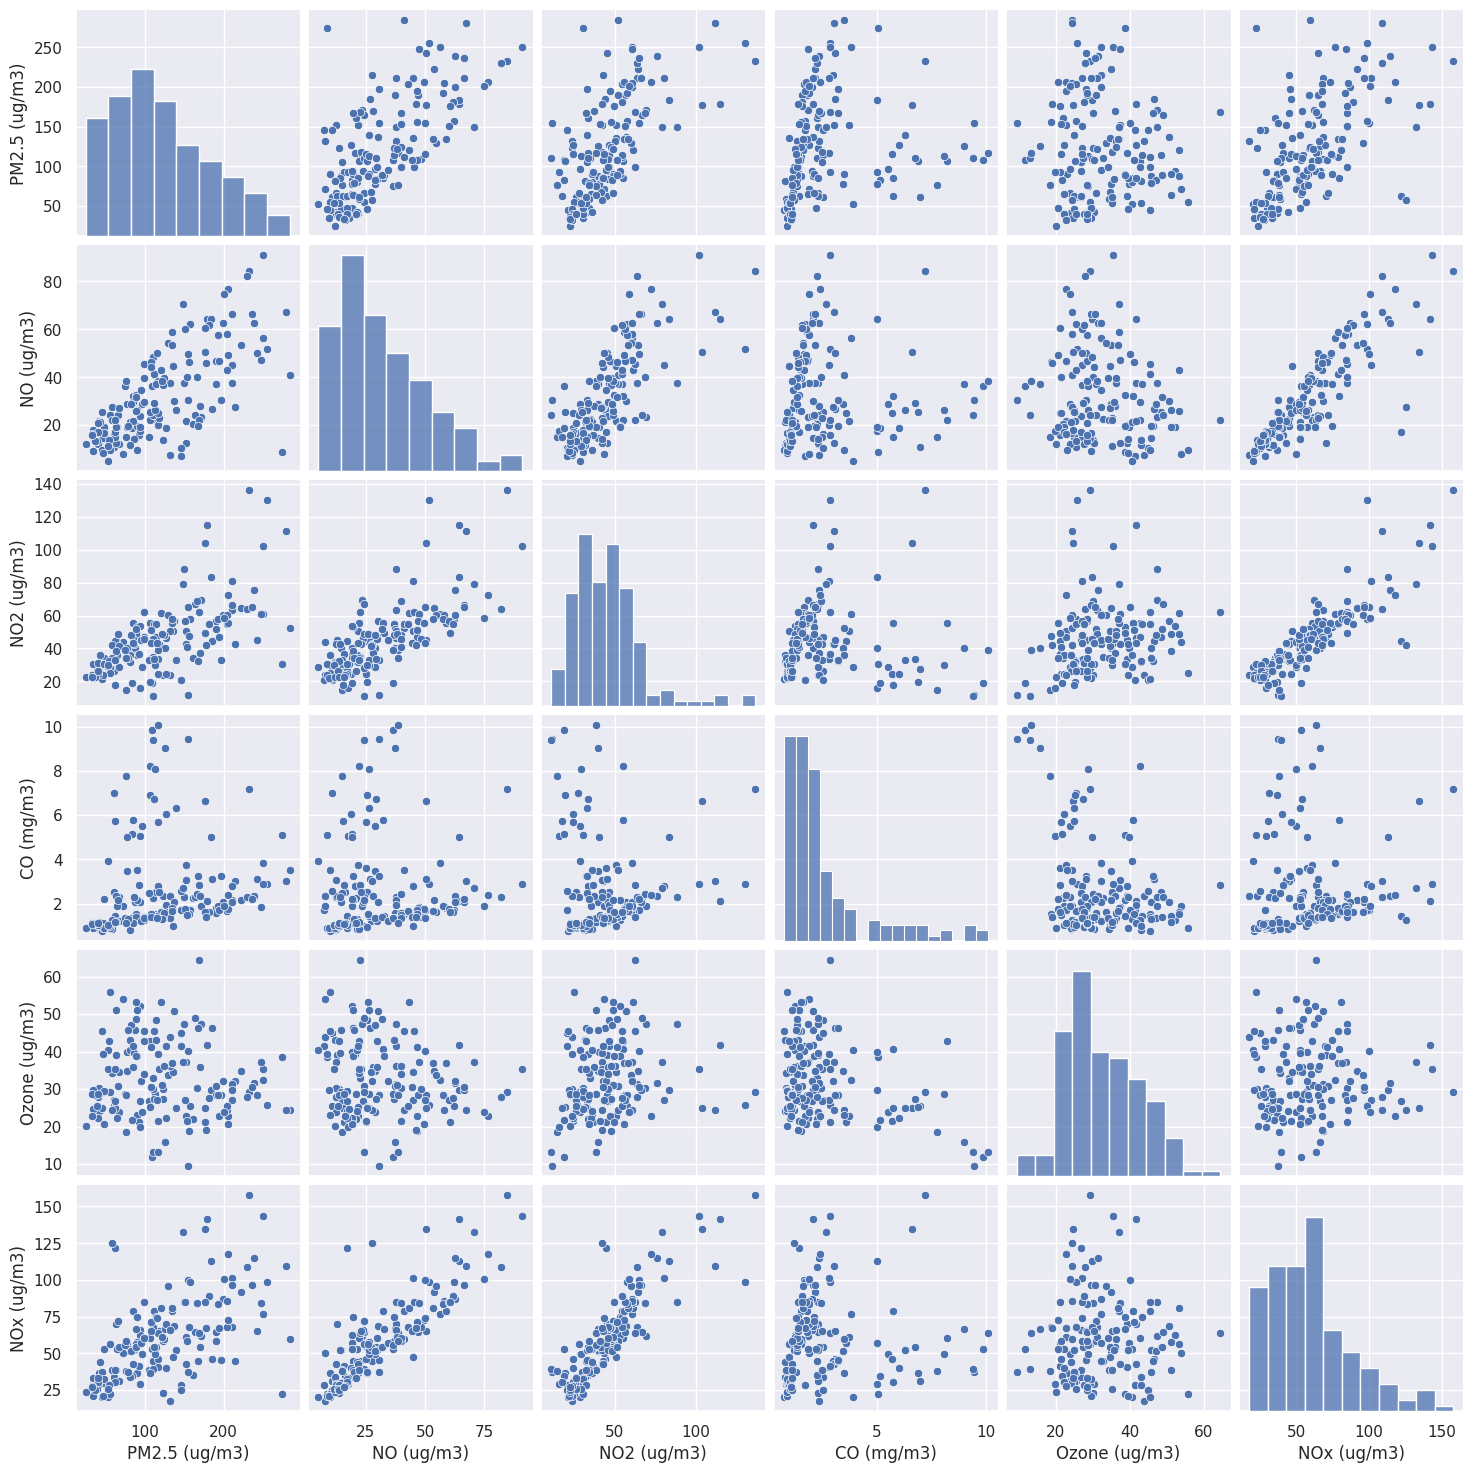

In [113]:
sns.pairplot(slice_groups['Group by Month'])

We can definatelly see here that the correlation between the Nitrogen Oxydes (NOx, NO, NO2) is quite linear.
This is expected and we should probably just keep the generic feature, which is `NOx`.

### Correlation Matrix

Through a correlation matrix, we can easily visuallize the correlation degree between the variables.

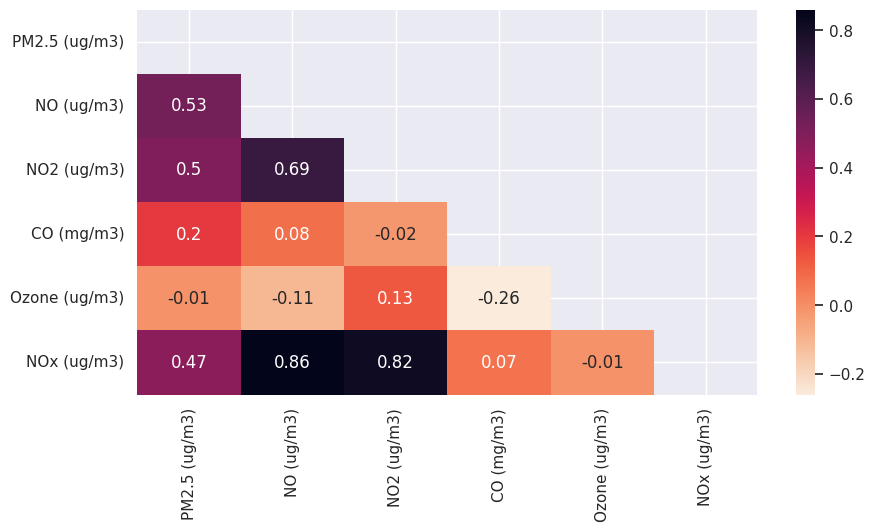

In [114]:
corr = slice_groups['Group by Day'].corr(numeric_only=True).round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,5))
sns.heatmap(data=corr, mask=mask, annot=True, cmap="rocket_r")
plt.show()

In [115]:
corr_target = abs(corr['PM2.5 (ug/m3)'])
relevant_features = corr_target[corr_target>0.4]
relevant_features.sort_values(ascending=False)

PM2.5 (ug/m3)    1.00
NO (ug/m3)       0.53
NO2 (ug/m3)      0.50
NOx (ug/m3)      0.47
Name: PM2.5 (ug/m3), dtype: float64

This plot shows us various high correlated features. For example:

- `NOx` is strongly correlated with the features `NO` and `NO2`.
- The particle accumulation feature `PM2.5` increases as the values of `NOx` increase.

Again, we see that it is fairly normal for the values of the *Nitrogen Compounds* to be highly correlated, as they represented in the same group.

## Feature Engineering

### Drop Correlated Features

In [116]:
df = df.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1)

### Resampling

Secondly, this combined dataframe can contain data for the same timeframe as measurements ware made from various locations within the state.
Here as I am interested in exploring the air quality in one state at a time, I will resample the same datetime measurements by taking the **mean** of the measurements.

In [117]:
df = df.resample('60min').mean(numeric_only=True)

### Outlier Detection and Removal

In general outliers are able to distort analyses and skew results. They are extreme values that can greatly differ from the rest of the data.
By removing the influence of such extreme data points we can make more robust and accurate predictions.

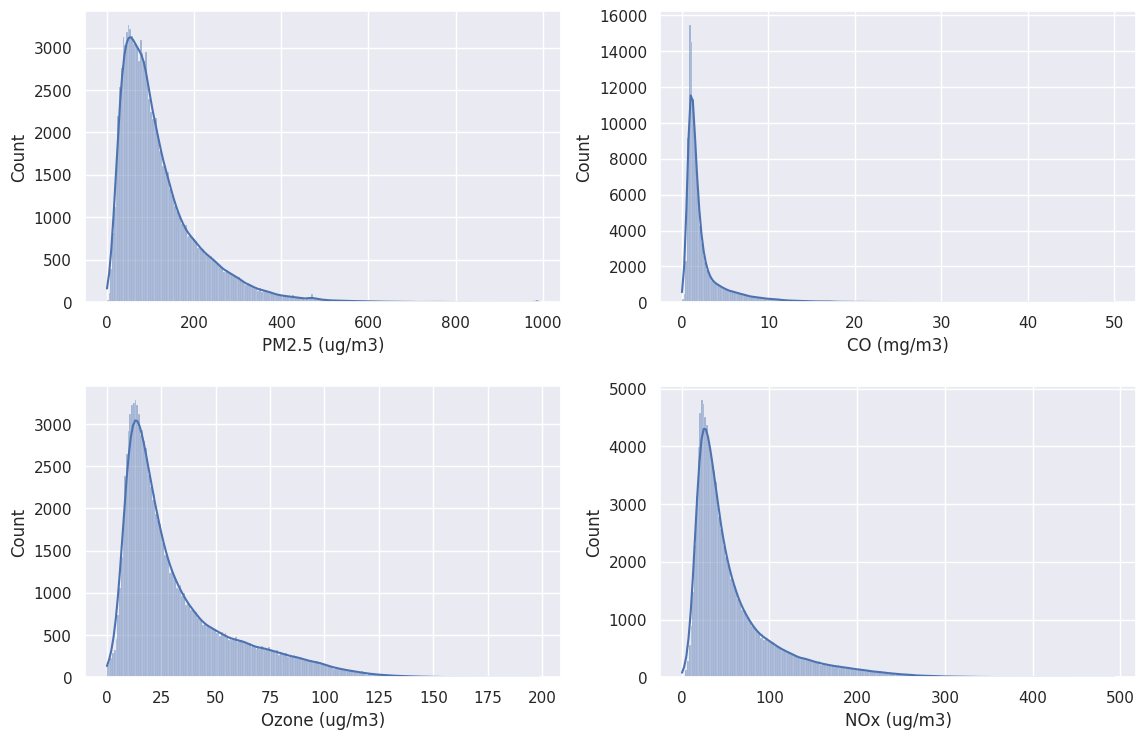

In [118]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout(pad=3.0)

sns.histplot(data=df['PM2.5 (ug/m3)'], bins=250, kde=True, ax=axes[0,0])
sns.histplot(data=df['CO (mg/m3)'], bins=250, kde=True, ax=axes[0,1])
sns.histplot(data=df['Ozone (ug/m3)'], bins=250, kde=True, ax=axes[1,0])
sns.histplot(data=df['NOx (ug/m3)'], bins=250, kde=True, ax=axes[1,1])

plt.show()

The first feature we will explore is the Particulate Matter `(PM2.5)`.

<Axes: xlabel='datetime'>

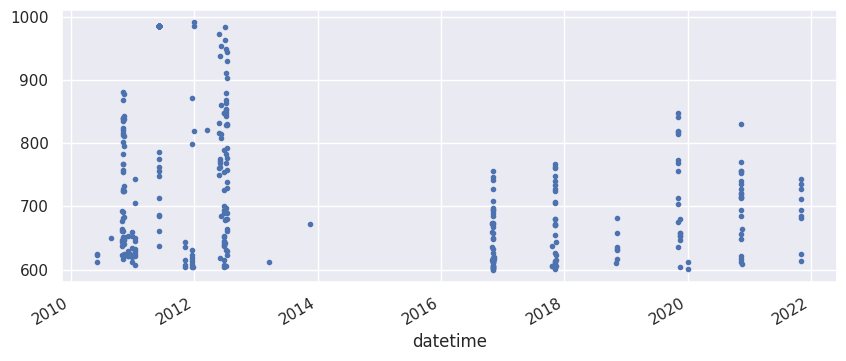

In [119]:
df.query('`PM2.5 (ug/m3)` > 600')['PM2.5 (ug/m3)'].plot(style='.', figsize=(10,4))

Here we can probably notice that we have just a few outliers above 950 around the year of 2012. I am going to remove them with caution.

In [120]:
df['PM2.5 (ug/m3)'] = df['PM2.5 (ug/m3)'].mask(df['PM2.5 (ug/m3)'].gt(950))

Next we explore potential outliers on the Carbon Monoxide `(CO)` feature.

<Axes: xlabel='datetime'>

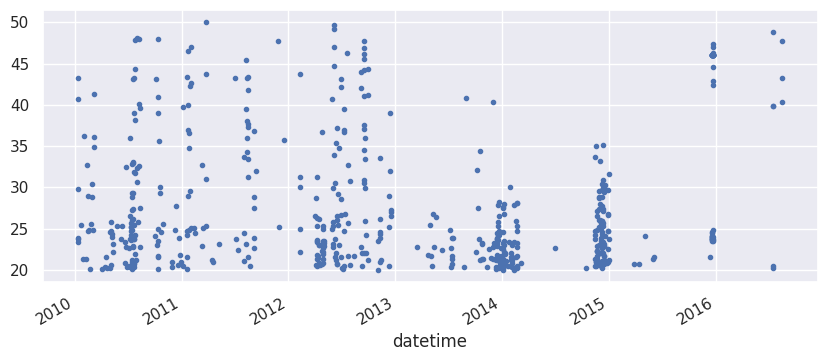

In [121]:
df.query('`CO (mg/m3)` > 20')['CO (mg/m3)'].plot(style='.', figsize=(10,4))

As you can see, this feature is quite noisy. However there is a group that caught my attention on the right side of the plot and after the year 2015. I will try to remove it.

In [122]:
df['CO (mg/m3)'] = df['CO (mg/m3)'].mask(((df.index > '2015') & df['CO (mg/m3)'].gt(35)))

Let's also explore the `Ozone` feature.

<Axes: xlabel='datetime'>

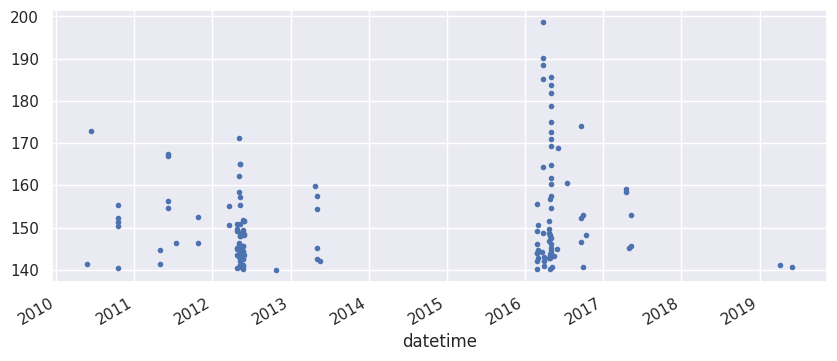

In [123]:
df.query('`Ozone (ug/m3)` > 140')['Ozone (ug/m3)'].plot(style='.', figsize=(10,4))

Here the outliers seem to be limited only around the middle 2016. I will just trim the extreme part of these measurements.

In [124]:
df['Ozone (ug/m3)'] = df['Ozone (ug/m3)'].mask(df['Ozone (ug/m3)'].gt(185))

Lastly we take a look at the Nitrogen Compounds `(NOx)` feature.

<Axes: xlabel='datetime'>

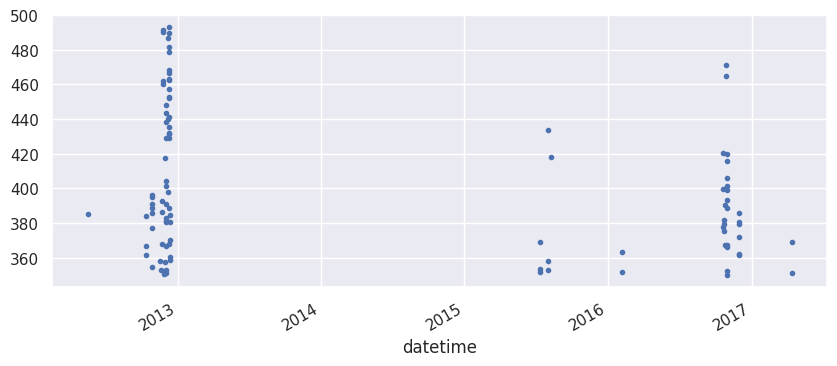

In [125]:
df.query('`NOx (ug/m3)` > 350')['NOx (ug/m3)'].plot(style='.', figsize=(10,4))

Again, we notice just a few extreme points that may be error data points. I will eliminate those.

In [126]:
df['NOx (ug/m3)'] = df['NOx (ug/m3)'].mask((
    ((df.index < '2013') & (df['NOx (ug/m3)'].gt(380))) |
    ((df.index > '2015') & (df.index < '2016') & (df['NOx (ug/m3)'].gt(400))) |
    ((df.index > '2016') & (df['NOx (ug/m3)'].gt(450)))
))

### Handling Missing Values

In [127]:
get_null_info(df)

,Null Count,Percent Missing (%)
PM2.5 (ug/m3),3908,3.37
CO (mg/m3),2123,1.83
NOx (ug/m3),104,0.09
Ozone (ug/m3),67,0.06


In [128]:
df = df.interpolate(method='pad')
df = df.fillna(df.mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116112 entries, 2010-01-01 00:00:00 to 2023-03-31 23:00:00
Freq: 60T
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   PM2.5 (ug/m3)  116112 non-null  float64
 1   CO (mg/m3)     116112 non-null  float64
 2   Ozone (ug/m3)  116112 non-null  float64
 3   NOx (ug/m3)    116112 non-null  float64
dtypes: float64(4)
memory usage: 4.4 MB


### Date Component Features

Let's prepare our dataset by enhancing it with useful features and separating it into training/testing splits.

In [129]:
def create_features(df):
    df = df.copy()
    df['hour']       = df.index.hour
    df['dayofmonth'] = df.index.day
    df['dayofweek']  = df.index.dayofweek
    df['dayofyear']  = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype("int64")
    df['month']      = df.index.month
    df['quarter']    = df.index.quarter
    df['year']       = df.index.year
    return df

In [130]:
date_features = ['hour', 'dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year']
df = create_features(df)

Now it is very easy to visualize the various metrics by the above features. One effective way is through boxplots. Let's for example check the air quality through the months.

In [131]:
def plot_by_datetime(metric, time_groups):
    for time_group in time_groups:
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.boxplot(data=df, x=time_group, y=metric, palette="icefire", showfliers=False)
        ax.set_title(f'{metric} by {time_group}')
        ax.set(xlabel=time_group)
        plt.show()

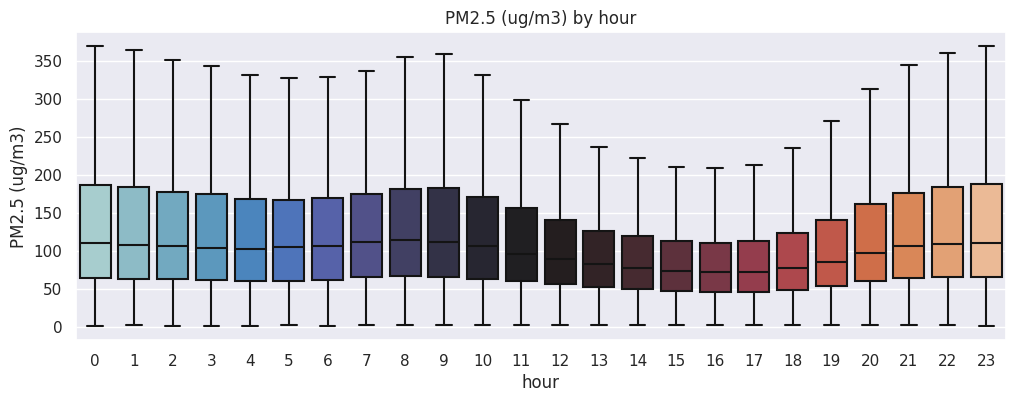

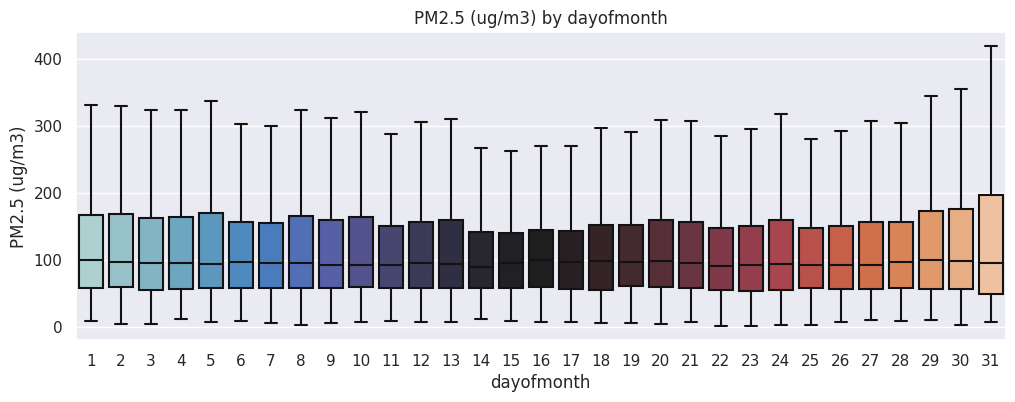

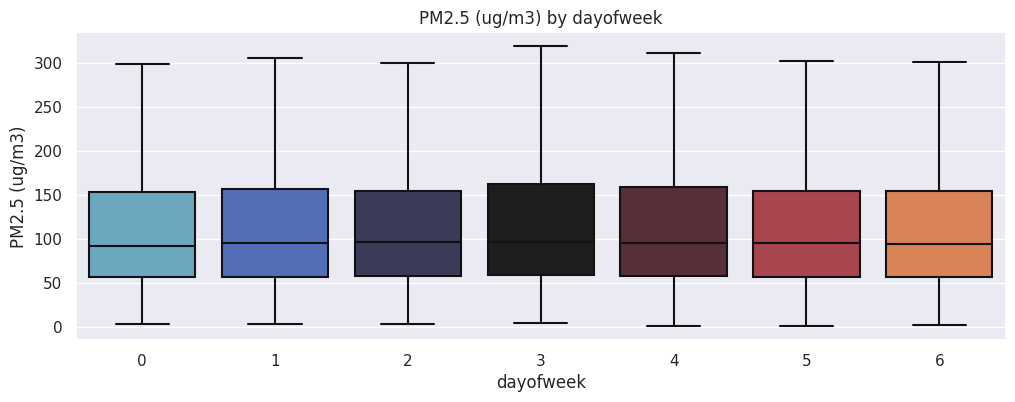

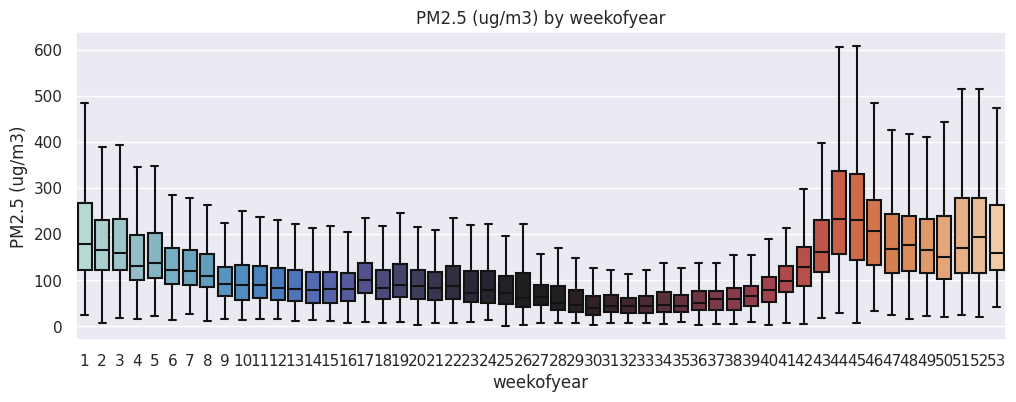

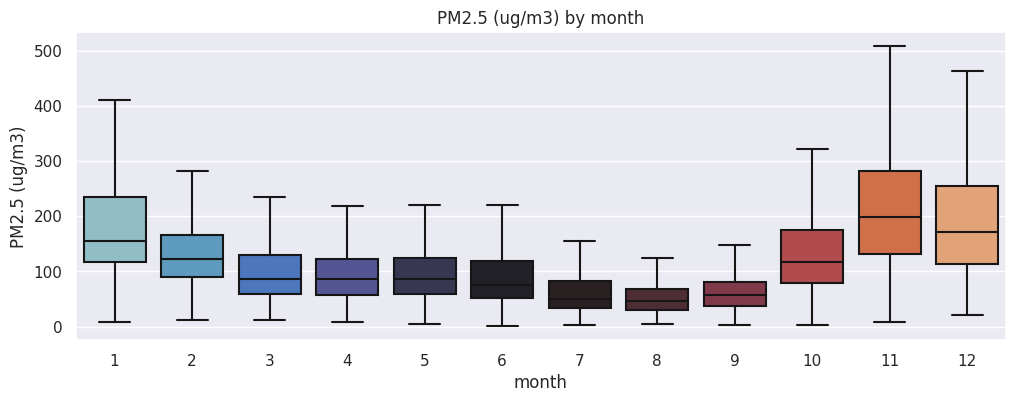

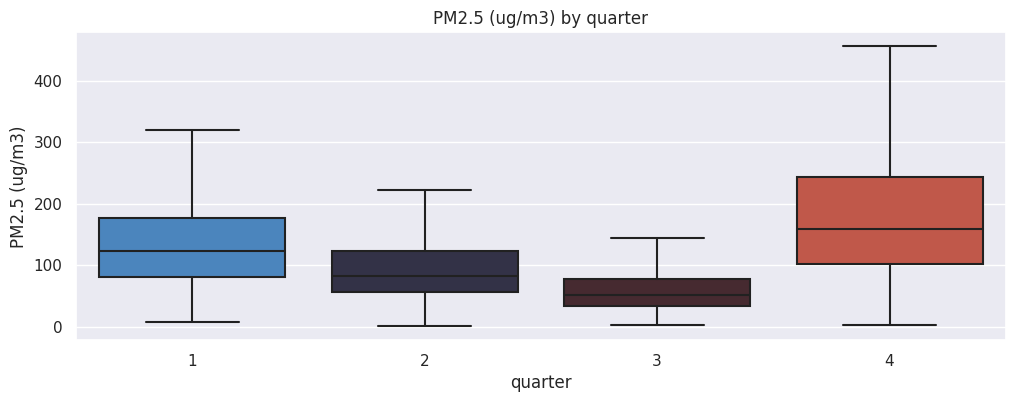

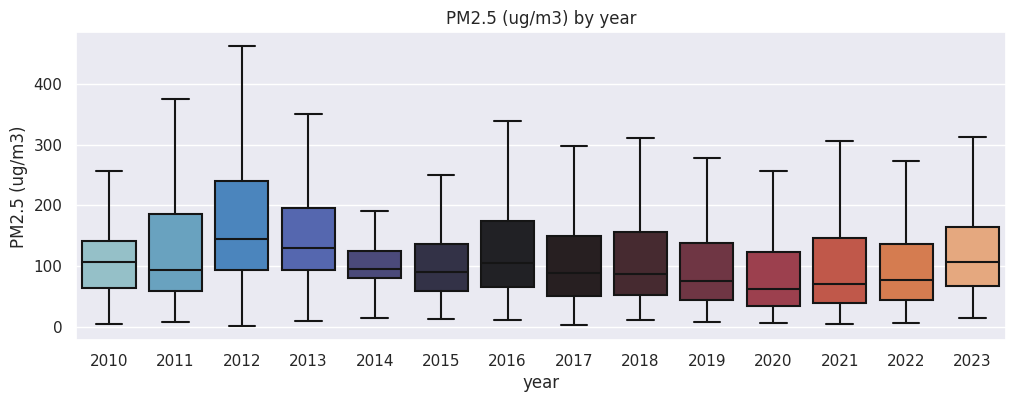

In [132]:
plot_by_datetime('PM2.5 (ug/m3)', ['hour', 'dayofmonth', 'dayofweek', 'weekofyear', 'month', 'quarter', 'year'])

These plots indicate that the various datetime groups capture important trends and information. What's also interesting here is that the 'dayofweek' feature vector, may not be as important, as it seems that the distribution is pretty similar to all days. Regardless, we will feed all this additional information to our model.

### Lag Features

Lag features capture information about a variable in a prior time step. In the case of forecasting, such lag features are likely to be predictive and help our models. What's more, we can also include lag features based on other predictive features in order to improve the forecasting accuracy.

From the previous few box plots we can see that some of the created timely features show some trends about the dataset. I will try to use some of these findings by creating appropriate lag features.

In [133]:
def create_lag_features(df):
    df = df.copy()
    df['pm_lag_1Y'] = df['PM2.5 (ug/m3)'].shift(365*24)   # 1 year lag
    df['pm_lag_2Y'] = df['PM2.5 (ug/m3)'].shift(730*24)   # 2 year lag
    return df

In [134]:
lag_features = ['pm_lag_1Y', 'pm_lag_2Y']
df = create_lag_features(df)
df.head()

,PM2.5 (ug/m3),CO (mg/m3),Ozone (ug/m3),NOx (ug/m3),hour,dayofmonth,dayofweek,dayofyear,weekofyear,month,quarter,year,pm_lag_1Y,pm_lag_2Y
datetime,,,,,,,,,,,,,,
2010-01-01 00:00:00,123.404029,2.340000,26.0650,73.7425,0,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 01:00:00,123.404029,2.327500,20.3425,36.0000,1,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 02:00:00,123.404029,2.177500,11.0650,27.1900,2,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 03:00:00,123.404029,1.992500,18.4625,21.1125,3,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 04:00:00,123.404029,2.096667,13.7500,23.1550,4,1,4,1,53,1,1,2010,NaN,NaN


After creating the lag features, we can see that the very first records (earliest measurements possible), have missing values. This is normal as we do not have previous observations that this point. However, we should be careful on how we deal with those values, as some models (especially sklearn's ensemble) do not support data with missing values.

For that reason I am going to create a function to deal with those values, for the ensemble models that do not support missing values. I should say that I am doing this purely for investigative reasons, to have some form of comparisons between models. This may introduce some bias and/or loose some information especially from the early year of measurements.

In [135]:
def replace_lag_na(df, how):
    '''
    Replaces missing values by applying various methods.

    Some additional ideas to implement include:
      1. Replace lag NaNs with the overall chosen method for that variable
      2. Replace lag NaNs with the time chosen method for the variable in the window value
    '''

    # Replace lag NaNs with zeros
    if how == 'zeros':
        return df.fillna(0)
    # Drop missing lag records
    if how == 'drop':
        return df.dropna(how='any')

## Time Series Forecasting

I will perform time series forecasting based on our extended analysis. I am going to compare various well known models, and present the results.

### Dataset Preparation

Since I will try to compare many models at once, some of these model do not support missing values introducted by the lag features. To be completely fair across models I will drop all of such records. However bare in mind that by doing so, I am deleting a year's worth of information. There are models, for instance XGBoost or sklearn's HistGradientBoosting regressor, which accept missing values.

In [136]:
target = 'PM2.5 (ug/m3)'
predictors = date_features + lag_features

In [137]:
def create_train_test_sets(dataframe, split, replace_na=False, method='none'):
    '''
    Creates the training and testing sets for prediction.

    Parameters
    ----------
        dataframe (DataFrame): The DataFrame to exctract the train and test sets
        split (float): The percentage to split the dataset
        replace_na (bool): Option to replace/remove missing values from the sets
        method (string): The method of dealing with missing values. Options include `zeros` or `drop`

    Return
    ------
        X_train (DataFrame): The training set
        X_test (DataFrame): The testing set
        y_train (Series): The y values of the training set
        y_test (Series): The y values of the testing set
    '''

    dataframe = dataframe.copy()

    if replace_na:
        dataframe = replace_lag_na(dataframe, how=method)

    train_set, test_set = np.split(dataframe, [int(len(df) * split)])
    return train_set[predictors], test_set[predictors], train_set[target], test_set[target]

In [138]:
X_train, X_test, y_train, y_test = create_train_test_sets(df, split=0.8, replace_na=True, method='drop')

### Ensemble Methods

In [139]:
RANDOM_STATE = 18
ensemble_models = {
    'Random Forest':     RandomForestRegressor(random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingRegressor(random_state=RANDOM_STATE),
    'XGBoost':           xgb.XGBRegressor(random_state=RANDOM_STATE)
}

I am going to use various metrics to score the models. In essence I will use the following:

1. $R^2$ (Coefficient of determination): This metric measures how well a statistical model predicts the dependent variable. The lowest possible value of $R^2$ is 0 and the highest possible value is 1. If the $R^2_{test} ≪ R^2_{train}$, then this indicates that our model does not generalize well to unseen data. **(Higher is better)**

2. Root Mean Squared Error: Without using the root or (`MSE`), it measures the *variance* of the residuals. The `RMSE` measures the *standard deviation* of the errors which occur when a prediction is made on a dataset. They both penalize large prediction errors. **(Lower is better)**

3. Mean Absolute Error: `MAE` measures the average of the absolute difference between the actual and predicted values in the dataset. It is not very sensitive to outliers since it doesn't punish huge errors. **(Lower is better)**

4. Mean Absolute Percentage Error: `MAPE` measures the accuracy of a forecast system. It captures how far off predictions are on average. **(Lower is better)**

In [140]:
def get_estimator_scores(models):
    '''
    Uses various metric algorithms to calculate various scores for multiple estimators
    '''
    metrics = []

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        predictions_test = model.predict(X_test)

        metrics.append([
            model_name,
            model.score(X_train, y_train),
            r2_score(y_test, predictions_test),
            np.sqrt(mean_squared_error(y_test, predictions_test)),
            mean_absolute_error(y_test, predictions_test),
            mean_absolute_percentage_error(y_test, predictions_test)
        ])

    return pd.DataFrame(metrics, columns=['model', 'r2_train', 'r2_test', 'rmse', 'mae', 'mape'])

In [141]:
estimator_scores = get_estimator_scores(ensemble_models)

In [142]:
def plot_estimator_scores(scores):
    melted_r2 = scores[['model', 'r2_train', 'r2_test']].rename(columns={"r2_train": "train", "r2_test": "test"})
    melted_r2 = melted_r2.melt(id_vars='model', var_name='set', value_name='score')

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.3, wspace=0.4)

    sns.barplot(data=melted_r2.round(2), x='score', y='model', hue='set', orient='h', ax=axes[0,0])
    sns.barplot(data=scores.round(2), x='rmse', y='model', orient='h', ax=axes[0,1])
    sns.barplot(data=scores.round(2), x='mae', y='model', orient='h', ax=axes[1,0])
    sns.barplot(data=scores.round(2), x='mape', y='model', orient='h', ax=axes[1,1])

    axes[0,0].set_title('R2 Score')
    axes[0,0].bar_label(axes[0,0].containers[0], size=10, padding=5)
    axes[0,0].bar_label(axes[0,0].containers[1], size=10, padding=5)
    axes[0,0].set(xlabel=None, ylabel=None)
    axes[0,0].set_xlim(0, max(melted_r2['score'])+.5)

    axes[0,1].set_title('Root Mean Squared Error')
    axes[0,1].bar_label(axes[0,1].containers[0], size=10, padding=5)
    axes[0,1].set(xlabel=None, ylabel=None)
    axes[0,1].set_xlim(0, max(scores['rmse'])+12)

    axes[1,0].set_title('Mean Absolute Error')
    axes[1,0].bar_label(axes[1,0].containers[0], size=10, padding=5)
    axes[1,0].set(xlabel=None, ylabel=None)
    axes[1,0].set_xlim(0, max(scores['mae'])+10)

    axes[1,1].set_title('Mean Absolute Percentage Error')
    axes[1,1].bar_label(axes[1,1].containers[0], size=10, padding=5)
    axes[1,1].set(xlabel=None, ylabel=None)
    axes[1,1].set_xlim(0, max(scores['mape'])+0.1)

    plt.plot()

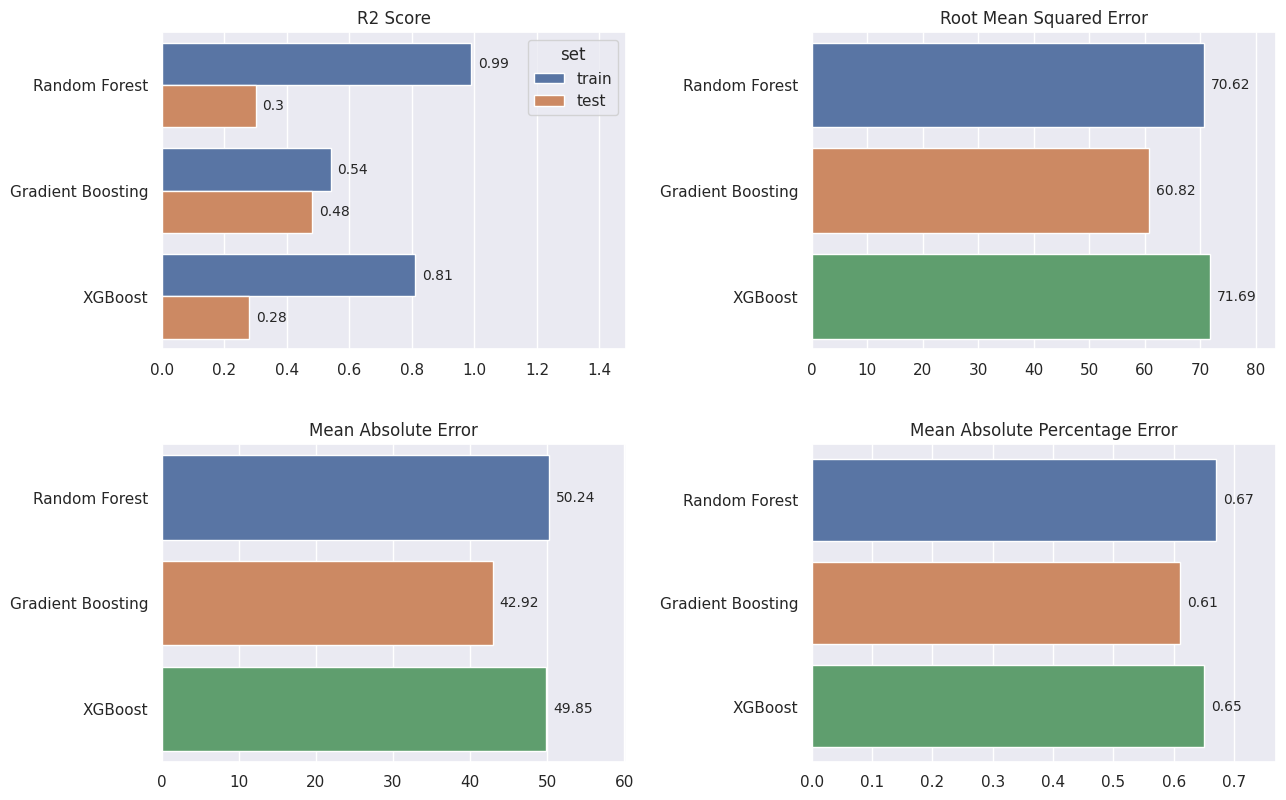

In [143]:
plot_estimator_scores(estimator_scores)

#### Cross-Validation

Cross-validation is a technique in machine learning that is used to evaluate predictive performance in estimators. On each iteration, the algorithm splits the input data into two parts, a training set and an evaluation set (folds). The model is then trained on the training fold, and its performance is evaluated against the other validation fold. It is mainly used when we want to estimate how accurately a predictive model will perform and generalize to unseen data.

In this notebook we are dealing with time series data. The dataset contains time records in ascending order and randomly spliting it into various folds will not be ideal, since we want to predict future values. In that case we use another kind of cross-validation called `TimeSeriesSplit`. This technique splits the time series data into fixed time intervals as train/test sets. These splits advance in time, with each new split containing records that must be higher than the previous one.

Let's actually observe the resulting splits for our testing dataset.

In [144]:
tscv = TimeSeriesSplit(n_splits=5)

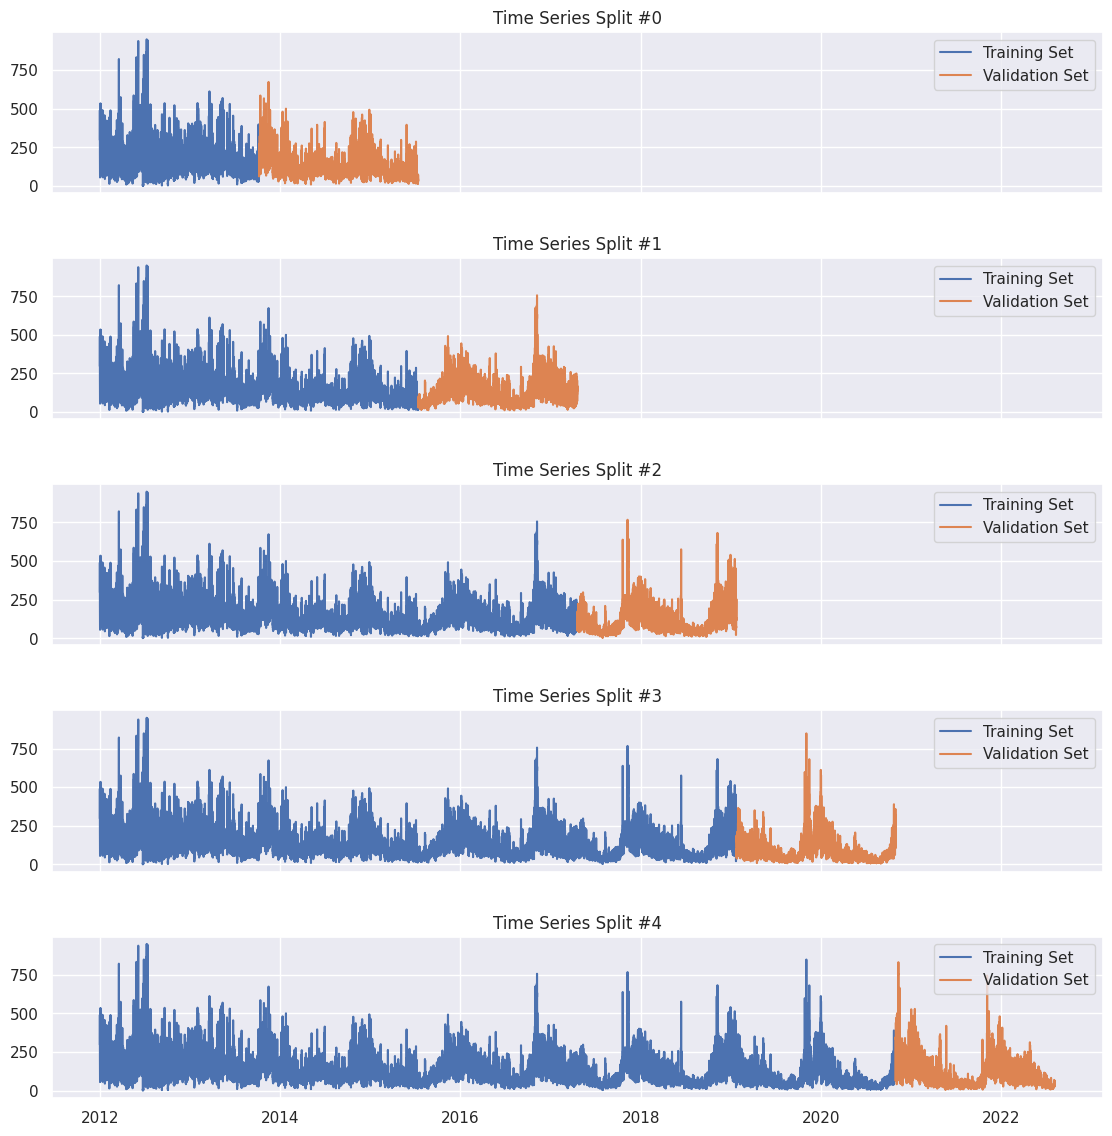

In [145]:
fig, axes = plt.subplots(tscv.n_splits, 1, figsize=(12, 12), sharex=True)
fig.tight_layout(pad=3.0)

for index, (train_fold, validation_fold) in enumerate(tscv.split(y_train)):
    sns.lineplot(data=y_train.iloc[train_fold], label='Training Set', ax=axes[index])
    sns.lineplot(data=y_train.iloc[validation_fold], label='Validation Set', ax=axes[index])
    axes[index].set_title(f'Time Series Split #{index}')
    axes[index].set(xlabel=None, ylabel=None)

plt.show()

Now I will perform cross-validation for all our models and share the results.

In [146]:
def get_cross_val_scores(models, x, y, cv, scoring):
    '''
    Get cross validated scores for input models.

    Parameters
    ----------
        models (dict): Dictionary containing the name of the model and the estimator object.
        x (DataFrame): A DataFrame containing the feature values to train upon.
        y (DataFrame): A Series object containing the actual predicted values.
        cv (CrossValidator or int): The cross-validation technique. An int value will perform k-fold CV.
        scoring (string): The scoring metric to evaluate the models.

    Return
    ------
        results (DataFrame): A DataFrame which contains the results for the CV run.
    '''

    measurements = [(model_name, i, score)
                    for model_name, model in ensemble_models.items()
                    for i, score in enumerate(-cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=N_JOBS))]

    results = pd.DataFrame(measurements, columns=['model', 'fold', 'score'])
    return results

In [147]:
N_JOBS = -1
cv_results = get_cross_val_scores(ensemble_models, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')

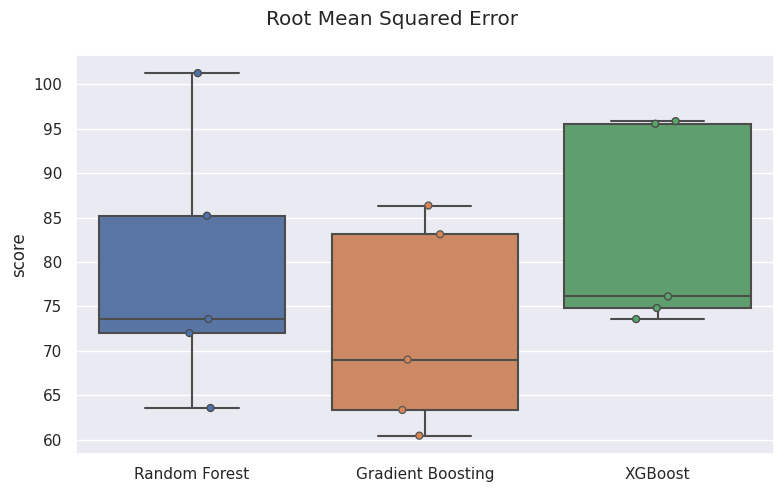

In [148]:
plt.figure(figsize=(8,5))
plt.suptitle('Root Mean Squared Error')

cs_metrics_bxplt = sns.boxplot(x='model', y='score', data=cv_results)
cs_metrics_stplt = sns.stripplot(x='model', y='score', hue='model', data=cv_results,
                                 size=5, jitter=True, linewidth=1, legend=False)

cs_metrics_bxplt.tick_params(labelsize=11)
cs_metrics_bxplt.set(xlabel=None)
plt.tight_layout()
plt.show()

In [149]:
cv_results.groupby('model').score.mean().sort_values()

model
Gradient Boosting    72.461480
Random Forest        79.124580
XGBoost              83.183521
Name: score, dtype: float64

#### Hyperparameter Tuning

We are now presented with design choices in order to achieve an optimal model architecture. These choices can be made with the form of parameters, which are refered to as **hyperparameters**. Those values are not automatically learned and we have to tune them. However we don't immediatelly know which parameters to tune and we may have to explore a huge range of possibilities. So we create a mapping of hyperparameters and the search space we want to explore.

This is where we can use two popular methods of hyperparameter tuning, the *GridSearch* and the *RandomSearch*. The first option exhaustively searches every possible combination of those hyperparaters which yields the best result at the cost of being extremelly slow. The latter option, picks random subsets of the search space thus being faster and usually providing an adequate result. I'm going to use *RandomSearch* for this notebook.

In [84]:
# Hyperparameter configurations for RandomizedSearch

model_hyperparameters = {
    'Random Forest': {'n_estimators': [100,150,200],
                      'min_samples_split': [2,5],
                      'min_samples_leaf': [2,4,10],
                      'max_depth': [5,10],
                      'n_jobs': [N_JOBS],
                      'random_state': [RANDOM_STATE]},

    'Gradient Boosting': {'learning_rate': np.arange(0.01,1,0.01),
                          'n_estimators': [100,200,300],
                          'min_samples_split': [2,5],
                          'min_samples_leaf': [1,4,10],
                          'max_depth': [3,5],
                          'n_iter_no_change': [10],
                          'tol': [0.01],
                          'random_state': [RANDOM_STATE]},


  'XGBoost': {'learning_rate': np.arange(0.01,1,0.01),
                'n_estimators': [20,50,100,250],
                'max_depth': [None,3,5],
                'eval_metric': ['rmse'],
                'early_stopping_rounds': [10],
                'n_jobs': [N_JOBS],
                'random_state': [RANDOM_STATE]}
}

In [150]:
def random_search_cv(models, params, n_iter, cv, scoring):
    '''
    Performs hyperparameter tuning using RandomizedSearch.

    Parameters
    ----------
        models (dict): Dictionary containing the name of the model and its respective estimator object.
        params (dict): Dictionary containing the name of the model and its respective hyperparameter spaces to search.
        n_iter (int): The number of candidates to choose from the search space.
        cv (CrossValidator or int): The cross-validation technique. An int value will perform k-fold CV.
        scoring (string): The scoring metric to evaluate the models.

    Return
    ------
        models (dict): A dictionary containing the name of the model and the tuned model parameters.
        model_scores (DataFrame): DataFrame indicating the model's name and the attained best score.
    '''

    print(f'Fitting {tscv.n_splits} folds for each of {n_iter} candidates, totalling {tscv.n_splits*n_iter} fits.\n')

    model_scores = []

    for model_name, model in ensemble_models.items():
        start = time.time()

        # Use RandomizedSearch as the search space is quite big. For more accurate results we can use GridSearch.
        rscv_model = RandomizedSearchCV(model, params[model_name],
                                        cv=cv,
                                        scoring=scoring,
                                        return_train_score=True,
                                        n_jobs=N_JOBS,
                                        n_iter=n_iter,
                                        random_state=RANDOM_STATE)

        if model_name == 'XGBoost':
            rscv_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)
        else:
            rscv_model.fit(X_train, y_train)
        end = time.time()

        print(f'Randomized Search CV for {model_name} finished after {round(end-start, 2)} seconds. Best parameters found:')
        print(f'{rscv_model.best_params_}\n')

        models[model_name] = rscv_model.best_estimator_
        model_scores.append((model_name, round(-rscv_model.best_score_, 4)))

    model_scores = pd.DataFrame(model_scores, columns=['model', 'score'])

    return models, model_scores

In [83]:
ensemble_models, rscv_scores = random_search_cv(ensemble_models, model_hyperparameters, n_iter=1, cv=tscv, scoring="neg_root_mean_squared_error")

Fitting 5 folds for each of 1 candidates, totalling 5 fits.

Randomized Search CV for Random Forest finished after 162.87 seconds. Best parameters found:
{'random_state': 18, 'n_jobs': -1, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}

Randomized Search CV for Gradient Boosting finished after 89.37 seconds. Best parameters found:
{'tol': 0.01, 'random_state': 18, 'n_iter_no_change': 10, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.9400000000000001}

Randomized Search CV for XGBoost finished after 5.98 seconds. Best parameters found:
{'random_state': 18, 'n_jobs': -1, 'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.23, 'eval_metric': 'rmse', 'early_stopping_rounds': 10}



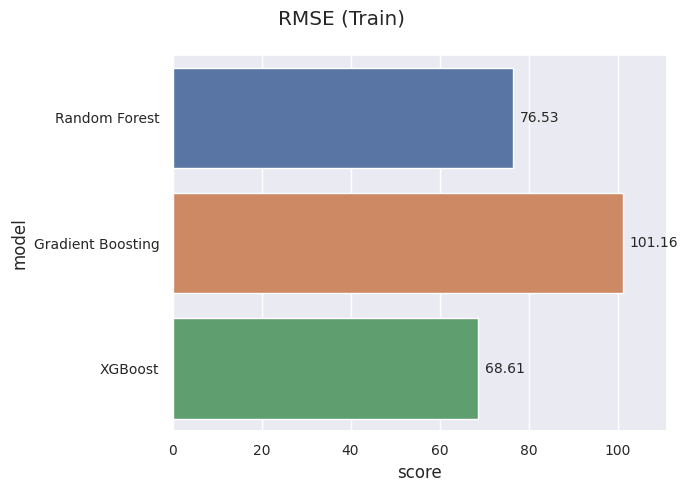

In [151]:
fig = plt.figure(figsize=(7,5))
fig.suptitle("RMSE (Train)")

metrics_plt = sns.barplot(rscv_scores.round(2), x='score', y='model', orient='h')
metrics_plt.tick_params(labelsize=10)
metrics_plt.bar_label(metrics_plt.containers[0], size=10, padding=5)

plt.xlim(0, max(rscv_scores.score)+10)
plt.tight_layout()
plt.show()

Let's now evaluate the tuned models on their ability to predict unseen data (testing set) and also measure the time needed to train and make predictions.

In [152]:
time_metrics = []
for model_name, model in ensemble_models.items():

    fit_start = time.time()
    if model_name == 'XGBoost':
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)
    else:
        model.fit(X_train, y_train)
    fit_end = time.time()

    pred_start = time.time()
    predictions_test = model.predict(X_test)
    pred_end = time.time()

    time_metrics.append([
        model_name,
        np.sqrt(mean_squared_error(y_test, predictions_test)),
        fit_end-fit_start,
        pred_end-pred_start
    ])

time_metrics = pd.DataFrame(time_metrics, columns=['model', 'rmse', 'fit_time', 'predict_time'])

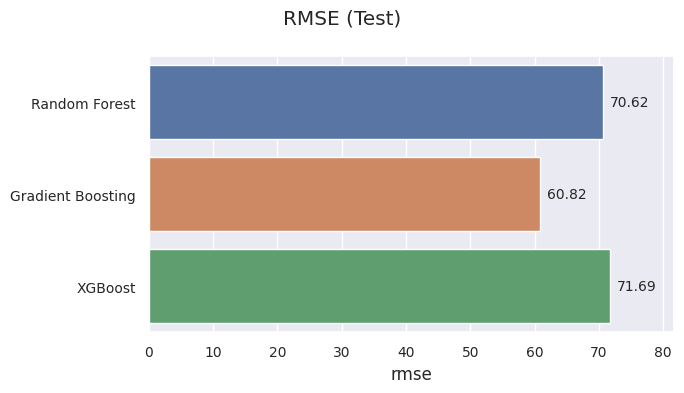

In [153]:
fig = plt.figure(figsize=(7,4))
fig.suptitle("RMSE (Test)")
metrics_plt = sns.barplot(time_metrics.round(2), x='rmse', y='model', orient='h')
metrics_plt.tick_params(labelsize=10)
metrics_plt.bar_label(metrics_plt.containers[0], size=10, padding=5)
metrics_plt.set(ylabel=None)

plt.xlim(0, max(time_metrics.rmse)+10)
plt.tight_layout()
plt.show()

All models perform similarly in the testing set as well. The lowest scores are given by `XGBoost` and `Random Forests`, by a tight margin.

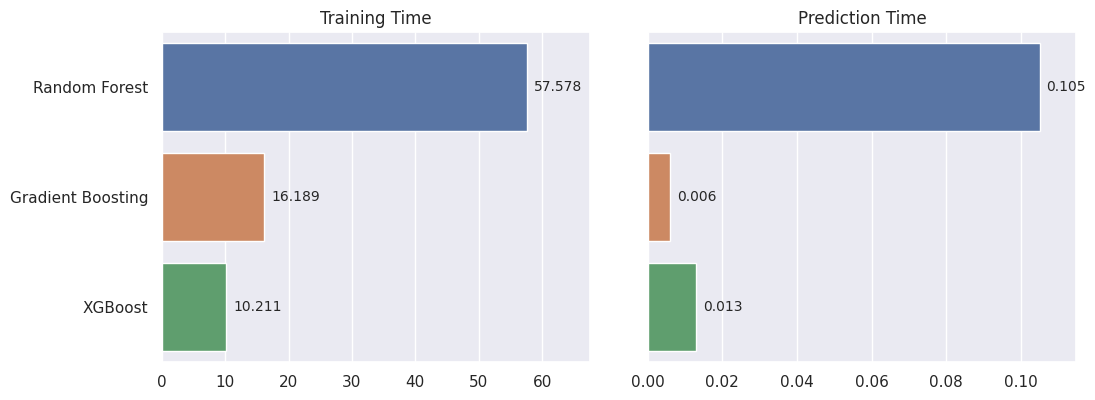

In [154]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
fig.tight_layout(w_pad=2.0)

sns.barplot(time_metrics.round(3), x='fit_time', y='model', orient='h', ax=axes[0])
axes[0].bar_label(axes[0].containers[0], size=10, padding=5)
axes[0].set_xlim(0, max(time_metrics.fit_time)+10)
axes[0].set(xlabel=None, ylabel=None)
axes[0].set_title('Training Time')

sns.barplot(time_metrics.round(3), x='predict_time', y='model', orient='h', ax=axes[1])
axes[1].bar_label(axes[1].containers[0], size=10, padding=5)
axes[1].set_xlim(0, max(time_metrics.predict_time)+0.01)
axes[1].set(xlabel=None, ylabel=None)
axes[1].set_title('Prediction Time')

plt.show()

Plotting the time needed for training and prediction, we can spot some differences. Random Forests and Gradient Boosting perform the worse when it comes to model training. In addition to this, Random Forests also have the worst performance during prediction. So in my opinion, if we were to choose one model it would be either the experimental `Histogram GB` or the pretty famous `XGBoost`.

#### Feature Importances

Feature Importance refers to the calculation of the score for all the input features for a given model. These scores represent the **importance** each feature that was assigned by the model. A higher score means that the specific feature has a higher influence on the model that is used to make predictions.

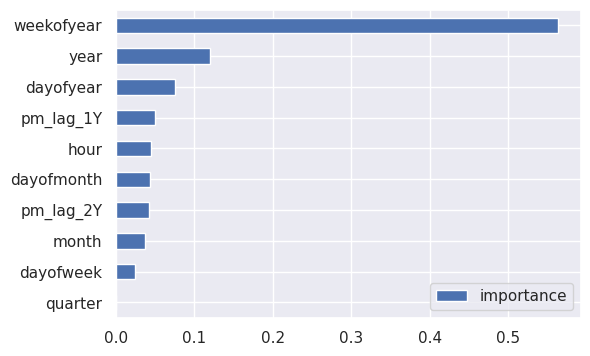

In [155]:
feature_importances_df = pd.DataFrame(data=ensemble_models['XGBoost'].feature_importances_,
                                      index=ensemble_models['XGBoost'].feature_names_in_,
                                      columns=['importance'])
feature_importances_df.sort_values('importance').plot(kind='barh', figsize=(6,4)).legend(loc='lower right')

#### Future Predictions

Next I will let these models make predictions on completely new data about the future (forecasting). We will also visually inspect the results to have a better understanding of how each model tries to come up with future predictions.

In [156]:
def create_future_dataset(raw_data, start_date, end_date):
    '''
    Get cross validated scores for input models.

    Parameters
    ----------
        raw_data (DataFrame): The original dataset to gather insights from.
        start_date (string): The starting date to use for forecasting.
        end_date (string): The last date to use for forecasting.

    Return
    ------
        future_dataset (DataFrame): A DataFrame which contains the created dataset with future datetime indices.
    '''

    future_dataset = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq='1H'), columns=['datetime'])
    future_dataset = future_dataset.set_index('datetime')
    future_dataset = create_features(future_dataset)

    # Create lag features from raw data
    future_dataset['pm_lag_1Y'] = raw_data.loc[future_dataset.index - pd.Timedelta('365 days')][target].values
    future_dataset['pm_lag_2Y'] = raw_data.loc[future_dataset.index - pd.Timedelta('730 days')][target].values

    return future_dataset

In [157]:
future_df = create_future_dataset(df, start_date='2023-04-01', end_date='2024-03-30')

# Make sure the order of the features is the same as the one we fed to the models.
f_names = ensemble_models['XGBoost'].get_booster().feature_names
future_df = future_df[f_names]

In [158]:
test_predictions = X_test.copy()
future_predictions = future_df.copy()

for model_name, model in ensemble_models.items():
    test_predictions[f'predict_{model_name}'] = model.predict(X_test)
    future_predictions[f'predict_{model_name}'] = model.predict(future_df)

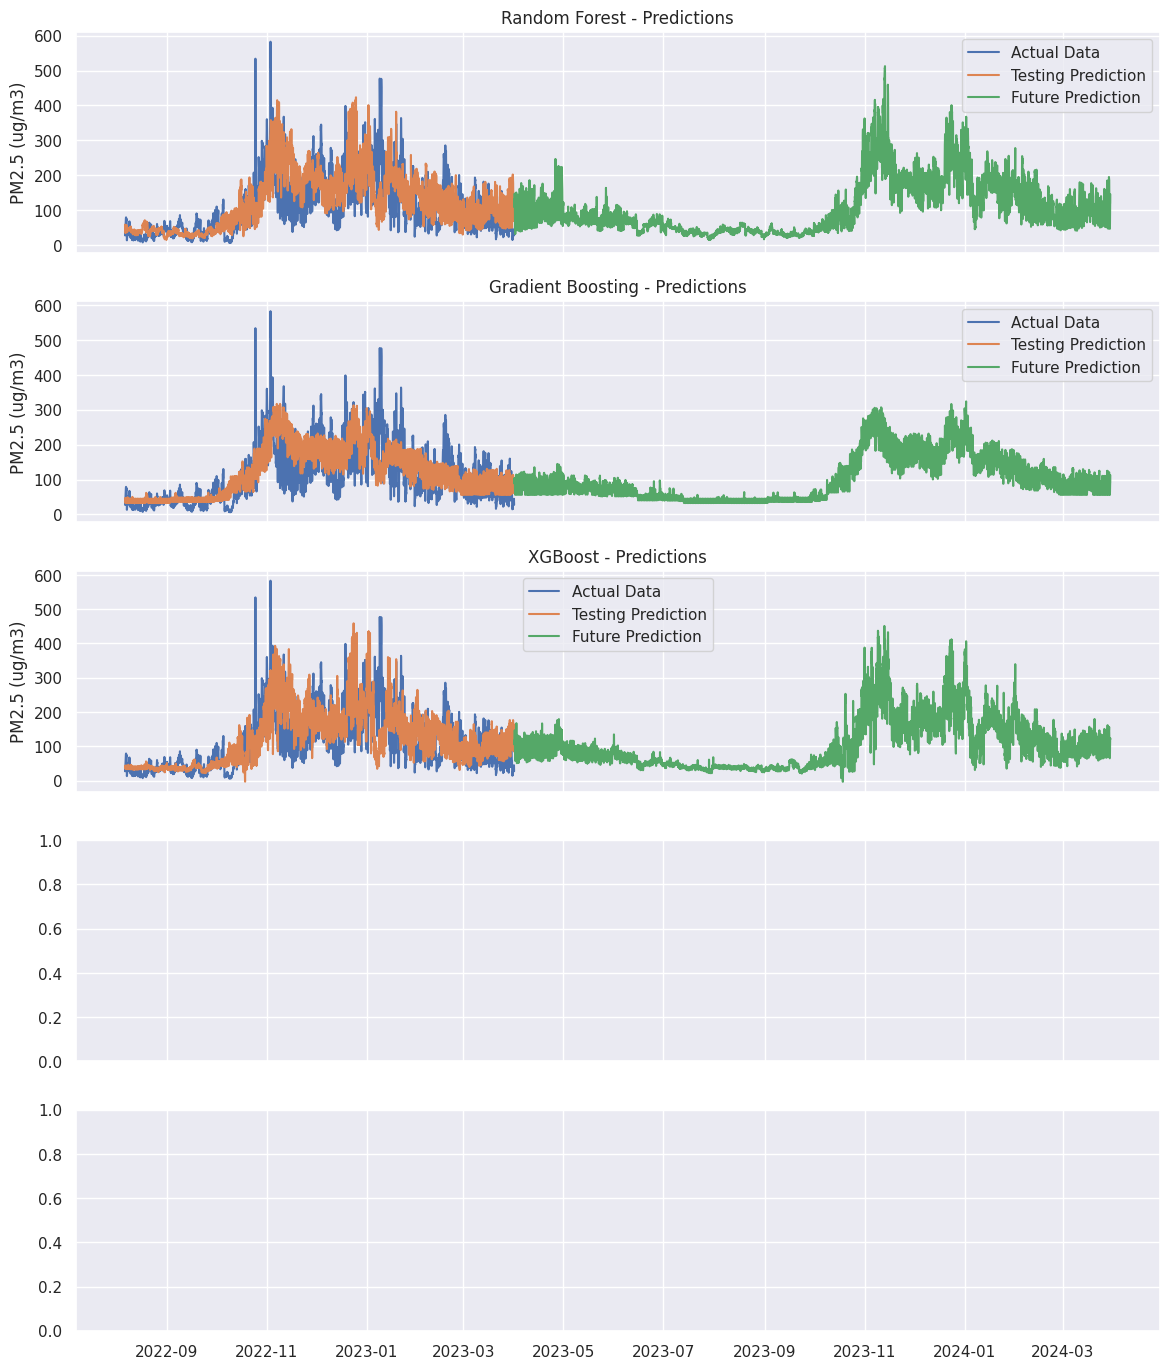

In [159]:
fig, axes = plt.subplots(5, 1, figsize=(12, 14), sharex=True)
fig.tight_layout(pad=2.0)

for index, (model_name, model) in enumerate(ensemble_models.items()):
    sns.lineplot(data=y_test, label="Actual Data", ax=axes[index])
    sns.lineplot(data=test_predictions[f'predict_{model_name}'], label="Testing Prediction", ax=axes[index])
    sns.lineplot(data=future_predictions[f'predict_{model_name}'], label="Future Prediction", ax=axes[index])
    axes[index].set_title(f'{model_name} - Predictions')
    axes[index].set(xlabel=None)

plt.show()

## Model Persistence

The results indicate that the XGBoost model performed the best for this task. I will save the model as a json file for easy loading.

In [160]:
try:
    os.mkdir('models')
except FileExistsError:
    pass

In [161]:
ensemble_models['XGBoost'].save_model('models/xgboost.json')

# Conclusion
1. Random Forests
It has score of 64

2. Gradient Boosting
It has score of 81

3. XGBoost         
It has score of 56

All models perform similarly in the testing set as well. The lowest scores is given by XGBoost.

# Summary & Insights

In this project, we have compared Gradient Boosting, Random forest regressor and XGBoost models. Following are the major conclusion of this study.

- EDA is an important step to develop insights on the given data.
- Feature engineering helps in transforming the data in format that is best fit for fitting into a model.
- Its always a good idea to compare two or more models to obtain best results.
- It is found that after hypertuning the parameters, the training loss for training and bigger training dataset has significantly improved when measured against the RMSLE loss.
- XG Boosting gives the best result for validation loss for RMSLE as compared to Gradient Boosting or Random Forests.

#Future Work

1. Implement more models to improve score like ARIMA and SARIMA

2. Can extract features from the target variable such as aggregrate, rolling stats since we have time-series data.

3. Will work on Unsupurvised Machine Learning problems.

4. Work on Deep learning and NLP projects.

# References
  
*   Random Forests : https://jovian.com/learn/zero-to-data-analyst-bootcamp/lesson/decision-trees-and-random-forests

*   Gradient Boosting Machines with XGBoost : https://jovian.ai/learn/zero-to-data-analyst-bootcamp/lesson/gradient-boosting-machines-with-xgboost

*   Stackoverflow and Geeksforgeeks

**Documentaion**

[1]. Scikit Learn Supervised Learning [Doc](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)  

[2]. XGBoost [Doc](https://xgboost.readthedocs.io/en/latest/)

[3]. RMSLE [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html)

**Tutorials**

[4]. How to approach Machine Learning Problems
[Jovian Aakash N S](https://jovian.ai/learn/zero-to-data-analyst-bootcamp)


[5]. Time Series Analysis, KASHISH RASTOGI: [Link](https://www.kaggle.com/code/kashishrastogi/store-sales-analysis-time-serie?scriptVersionId=81112640)

[6]. More Data Info: [Link](https://rpubs.com/yongks/favorita)

[7]. Walmart Store Sales Forecasting, Anushree: [Link](https://jovian.ai/anushree-k/final-walmart-simple-rf-gbm#C0)

[8]. Ensemble : [Link](https://www.metoffice.gov.uk/research/weather/ensemble-forecasting/what-is-an-ensemble-forecast#:~:text=Instead%20of%20running%20just%20a,future%20state%20of%20the%20atmosphere)

**Queries**

[9]. Jobot, ChatGPT, StackOverflow, GeekforGeeks